# PSO for Time Series LSTM

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

### Import Data

In [2]:
# France
df = pd.read_excel('LSTM.xlsx', usecols=[1], nrows=10000)

#df=df[0:2500]
df.shape

(10000, 1)

In [3]:
np.random.seed(7)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)
df=pd.DataFrame(dataset)
df.columns=['Consumption']
df.head()

,Consumption
0,0.61
1,0.62
2,0.62
3,0.62
4,0.58


## Deep Learning : LSTM

In [4]:
import pandas
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.layers import Activation, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Training using PSO Model Parameters

In [5]:
import operator
import random

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
from time import time

C:\Users\Ali\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [6]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, 
    smin=None, smax=None, best=None)

In [7]:
def generate(size, pmin, pmax, smin, smax):
    #part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size))
    part = creator.Particle(random.randint(pmin, pmax) for _ in range(size))
    #part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.speed = [random.randint(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

In [8]:
def updateParticle(part, best, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if speed < part.smin:
            part.speed[i] = part.smin
        elif speed > part.smax:
            part.speed[i] = part.smax
    part[:] = list(map(operator.add, part, part.speed))

In [25]:
# no to be mapped, max,min of input, max,min of output
def remap(x, in_min, in_max, out_min, out_max):
    #a= round((x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min)
    a= (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min
    a=int(a)
    return a

In [24]:
remap(0,-40,40,1,100)

50

In [10]:
# Objective Function

def train_evaluate(params):
    df1= df.copy(deep=True)
    #print('Original Data Shape', df1.shape)
    
    # Paramerts to be optimized 

    print('\nReceived following inputs from PSO: ',params)
    
    no_wins = int(params[0])
    no_wins=remap(no_wins,-40,40,1,5)
    #print('Number of Windows:',no_wins)
    if no_wins==5:
        no_wins=2
    if no_wins==0:
        no_wins=3
    if no_wins>=6 or no_wins<0:
        return 0.10,
    
    # Window length from 4 to 16
    win_len =int(params[1])
    window_length=remap(win_len,-40,40,3,18)
    if window_length>18 or window_length<3:
        return 0.10,
    
    # Max lookback upto 1440
    first_win =int(params[2])
    first_win=remap(first_win,-40,40,100,1)
    if first_win==0:
        first_win+=1
    if first_win in np.arange(-12,1): 
        first_win=abs(first_win) 
    if first_win>100:
        return 0.10
    
    sec_win =int(params[3])
    sec_win=remap(sec_win,-40,40,1400,1)
    if sec_win==0:
        sec_win+=1
    if sec_win in np.arange(-12,1): 
        sec_win=abs(sec_win) 
    if sec_win>1400 or sec_win<-12:
        return 0.10,
    
    third_win =int(params[4])
    third_win=remap(third_win,-40,40,1400,1)
    if third_win==0:
        third_win+=1
    if third_win in np.arange(-12,1): 
        third_win=abs(third_win) 
    if third_win>1400 or third_win<-12:
        return 0.10,
    
    fourth_win=int(params[5])
    fourth_win=remap(fourth_win,10,80,1400,1)
    if fourth_win==0:
        fourth_win+=1
    if fourth_win in np.arange(-10,1): 
        fourth_win=abs(fourth_win) 
    if fourth_win>1400 or fourth_win<-10:
        return 0.10,
    
    # Prevent Overlapping
        #1 & 2
    if first_win-sec_win in list(range(0,41)):
        if sec_win>48:
            sec_win-=40
        else:
            sec_win+=96
    if first_win-sec_win in list(range(-39,0)):
        sec_win+=30
    
    #1 & 3
    if first_win-third_win in list(range(0,41)):
        if third_win>48:
            third_win-=40
        else:
            third_win+=96
    if first_win-third_win in list(range(-39,0)):
        third_win+=30  
        
    # 1 & 4
    if first_win-fourth_win in list(range(0,41)):
        if fourth_win>48:
            fourth_win-=40
        else:
            fourth_win+=96
            
    if first_win-fourth_win in list(range(-39,0)):
        fourth_win+=30
    
    #2 & 3
    if sec_win-third_win in list(range(0,41)):
        if third_win>48:
            third_win-=40
        else:
            third_win+=96
    if sec_win-third_win in list(range(-39,0)):
        third_win+=30
    #Rep
    if first_win-third_win in list(range(-16,16)):
        return 0.10,
              
    #
     #2 & 4   
    if sec_win-fourth_win in list(range(0,41)):
        if fourth_win>48:
            fourth_win-=40
        else:
            fourth_win+=96
    if sec_win-fourth_win in list(range(-39,0)):
        fourth_win+=30
    #Rep
    if first_win-fourth_win in list(range(-16,16)):
        return 0.10,
        
    
    # 3 & 4    
    if third_win-fourth_win in list(range(0,41)):
        if fourth_win>48:
            fourth_win-=40
        else:
            fourth_win+=96
    if third_win-fourth_win in list(range(-39,0)):
        fourth_win+=30
    #Rep
    if first_win-fourth_win in list(range(-16,16)):
        return 0.10,
    if sec_win-fourth_win in list(range(-16,16)):
        return 0.10,
    
           
    num_units = int(params[6])
    num_units=abs(num_units)
    num_units+=20
    if num_units>=100:
        num_units=90
        
    # Minimum Batch Size is 25
    batch_size = int(params[7])
    batch_size=abs(batch_size)
    batch_size=batch_size+25
    if batch_size>150:
        return 0.10,
    
    act=int(params[8])
    print('Activation No is',act)
    act=remap(act,-40,40,1,5)
    print('Act Integer is:',act)
    
    if act==1:
        act='selu'
    elif act==2:
        act='elu'
    elif act==3:
        act='relu'
    elif act==4:
        act='tanh'
    elif act>=5 or act<1:
        return 0.10,

    
    opt=int(params[9])
    print ('Optimizer No is',opt)
    opt=remap(opt,-40,40,1,5)
    print('Optimizer Integer is',opt)
    
    if opt==1:
        opt='sgd'
    elif opt==2:
        opt='RMSprop'
    elif opt==3:
        opt='Adamax'
    elif opt==4:
        opt='Adam'
    elif opt>=5 or opt<1:
        return 0.10,
    
    # Return fitness score of 100 if window_size or num_unit is zero
    #if no_wins==0 or window_length == 0 or num_units == 0 or batch_size==0:
    #return 1, 
    
    if no_wins==1:
        lag=np.arange(first_win,first_win+window_length,1)
    elif no_wins==2:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag=np.concatenate([lag1,lag2])
    elif no_wins==3:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag3=np.arange(third_win,third_win+window_length,1)
        lag=np.concatenate([lag1,lag2,lag3])
    elif no_wins==4:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag3=np.arange(third_win,third_win+window_length,1)
        lag4=np.arange(fourth_win,fourth_win+window_length,1)
        lag=np.concatenate([lag1,lag2,lag3,lag4])  
    
    for col in df1.columns:
        for l in lag:
            df1.loc[:,col+"_"+str(l)] = df1[col].shift(l)
        
    df1.dropna(how='any',inplace=True)
    dataset = df1.values # Converted dataframe to numpy ndarray
    dataset = dataset.astype('float32')
    print('\nDataset shape after creating new lags:',dataset.shape)
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))
    
    trainX=train[:,1:]
    trainY=train[:,0]
    testX=test[:,1:]
    testY=test[:,0]
    
          
    print('\n Number of Windows/Inputs to LSTM are:',no_wins)
    print('Window Length: ', window_length)
    print('1st Window Start: ',first_win)
    print('2nd Window Start:',sec_win)
    print('3rd Window Start:',third_win)
    print('4th Window Start:',fourth_win)
    
    print('Num of LSTM Units: ', num_units)
    print('Batch Size is: ', batch_size)
    print('Activation is: ', act)
    print('Optimizer is: ', opt)
    print('Lag created are:', lag)
    
    
    #LSTM
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0],window_length,(no_wins)))
    testX = np.reshape(testX, (testX.shape[0],window_length,(no_wins)))
    print('Train X shape after np.reshape',trainX.shape)
    print('Test X shape after np.reshape',testX.shape)
    print('Train Y Shape',trainY.shape)
    print('Test Y Shape',testY.shape)
      
    # Train LSTM model and predict on validation set
    #inputs = Input(shape=(window_size,1))
    model = Sequential() # New Instance of Model Object
    model.add(LSTM(num_units, input_shape=(window_length,(no_wins))))
    model.add(Dense(30, activation=act))
    model.add(Dense(10, activation=act))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=opt,loss='mean_squared_error')
    #model.fit(trainX, trainY, epochs=1, batch_size=10,shuffle=True)
    
    start = time.time()
    model.fit(trainX, trainY, epochs=50, shuffle=True,batch_size=batch_size, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)
    
    y_pred = model.predict(testX)
    end = time.time()
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(testY, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    print ("Model took %0.2f seconds to train"%(end - start))
    return rmse,

In [18]:
remap(-38,-40,40,1400,1)

NameError: name 'remap' is not defined

## ToolBox Functions

In [11]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=10, pmin=-34, pmax=34, smin=-4, smax=4)

toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=1.5, phi2=3)
toolbox.register("evaluate", train_evaluate)

## Algorithm

In [12]:
from keras.callbacks import EarlyStopping
import time

In [13]:
def main():
    random.seed(64)
    pop = toolbox.population(n=18)
    print('Total population generated are:',len(pop))
    #print(pop)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    GEN = 30
    print('Total Generations are: ',GEN)
    best = None

    for g in range(GEN):
        print('Current Generation is:',g)
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
        for part in pop:
            toolbox.update(part, best)

        # Gather all the fitnesses in one list and print the stats
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        print(logbook.stream)
        print (" %s Best so far: %s - fitness %s" % (g,best, best.fitness))
    
    return pop, logbook, best
pop,logbook,best= main()

Total population generated are: 18
Total Generations are:  30
Current Generation is: 0

Received following inputs from PSO:  [-1, -27, -30, 33, 33, -30, -33, 21, -24, 0]

Received following inputs from PSO:  [14, 10, -13, -1, 32, 3, 21, -6, 34, 8]

Received following inputs from PSO:  [18, -22, 3, 0, 34, -10, 24, -25, -33, -21]

Received following inputs from PSO:  [6, 32, 33, 34, 26, 19, -29, 10, -14, -28]
Activation No is -14
Act Integer is: 2
Optimizer No is -28
Optimizer Integer is 1

Dataset shape after creating new lags: (50740, 49)
40592 10148

 Number of Windows/Inputs to LSTM are: 3
Window Length:  16
1st Window Start:  9
2nd Window Start: 105
3rd Window Start: 245
4th Window Start: 1220
Num of LSTM Units:  49
Batch Size is:  35
Activation is:  elu
Optimizer is:  sgd
Lag created are: [  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 245 246 247 248
 249 250 251 252 253 254 255 256 257 258 259 260]



Dataset shape after creating new lags: (49921, 40)
39936 9985

 Number of Windows/Inputs to LSTM are: 3
Window Length:  13
1st Window Start:  72
2nd Window Start: 333
3rd Window Start: 1067
4th Window Start: 1400
Num of LSTM Units:  25
Batch Size is:  39
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  72   73   74   75   76   77   78   79   80   81   82   83   84  333
  334  335  336  337  338  339  340  341  342  343  344  345 1067 1068
 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079]
Train X shape after np.reshape (39936, 13, 3)
Test X shape after np.reshape (9985, 13, 3)
Train Y Shape (39936,)
Test Y Shape (9985,)
Train on 39936 samples, validate on 9985 samples
Epoch 1/50
39936/39936 [==============================] - 5s 137us/step - loss: 0.0110 - val_loss: 0.0055
Epoch 2/50
39936/39936 [==============================] - 5s 123us/step - loss: 0.0073 - val_loss: 0.0052
Epoch 3/50
39936/39936 [==============================] - 5s 126us/step - loss: 0.0068 - v

40775/40775 [==============================] - 4s 97us/step - loss: 0.0110 - val_loss: 0.0111
Epoch 15/50
40775/40775 [==============================] - 4s 98us/step - loss: 0.0110 - val_loss: 0.0114
Epoch 16/50
40775/40775 [==============================] - 4s 100us/step - loss: 0.0110 - val_loss: 0.0102
Epoch 17/50
40775/40775 [==============================] - 4s 98us/step - loss: 0.0109 - val_loss: 0.0104
Epoch 18/50
40775/40775 [==============================] - 4s 97us/step - loss: 0.0109 - val_loss: 0.0115
Epoch 19/50
40775/40775 [==============================] - 4s 98us/step - loss: 0.0109 - val_loss: 0.0097
Epoch 20/50
40775/40775 [==============================] - 4s 100us/step - loss: 0.0108 - val_loss: 0.0103
Epoch 21/50
40775/40775 [==============================] - 4s 97us/step - loss: 0.0108 - val_loss: 0.0111
Epoch 22/50
40775/40775 [==============================] - 4s 99us/step - loss: 0.0108 - val_loss: 0.0096
Epoch 23/50
40775/40775 [==============================]

Epoch 24/50
40536/40536 [==============================] - 7s 183us/step - loss: 0.0100 - val_loss: 0.0092
Epoch 25/50
40536/40536 [==============================] - 7s 180us/step - loss: 0.0099 - val_loss: 0.0091
Epoch 26/50
40536/40536 [==============================] - 7s 181us/step - loss: 0.0098 - val_loss: 0.0094
Epoch 27/50
40536/40536 [==============================] - 7s 181us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 28/50
40536/40536 [==============================] - 7s 179us/step - loss: 0.0096 - val_loss: 0.0088
Epoch 29/50
40536/40536 [==============================] - 7s 184us/step - loss: 0.0095 - val_loss: 0.0087
Epoch 30/50
40536/40536 [==============================] - 7s 181us/step - loss: 0.0094 - val_loss: 0.0086
Epoch 31/50
40536/40536 [==============================] - 7s 184us/step - loss: 0.0094 - val_loss: 0.0085
Epoch 32/50
40536/40536 [==============================] - 7s 179us/step - loss: 0.0093 - val_loss: 0.0091
Epoch 33/50
40536/40536 [============

Train on 39849 samples, validate on 9963 samples
Epoch 1/50
39849/39849 [==============================] - 4s 106us/step - loss: 0.0253 - val_loss: 0.0235
Epoch 2/50
39849/39849 [==============================] - 4s 88us/step - loss: 0.0244 - val_loss: 0.0226
Epoch 3/50
39849/39849 [==============================] - 3s 84us/step - loss: 0.0236 - val_loss: 0.0219
Epoch 4/50
39849/39849 [==============================] - 3s 84us/step - loss: 0.0228 - val_loss: 0.0212
Epoch 5/50
39849/39849 [==============================] - 3s 85us/step - loss: 0.0219 - val_loss: 0.0208
Epoch 6/50
39849/39849 [==============================] - 3s 84us/step - loss: 0.0210 - val_loss: 0.0201
Epoch 7/50
39849/39849 [==============================] - 4s 88us/step - loss: 0.0199 - val_loss: 0.0193
Epoch 8/50
39849/39849 [==============================] - 3s 85us/step - loss: 0.0188 - val_loss: 0.0177
Epoch 9/50
39849/39849 [==============================] - 3s 85us/step - loss: 0.0178 - val_loss: 0.0173
Epoch

40591/40591 [==============================] - 9s 228us/step - loss: 0.0035 - val_loss: 0.0029
Epoch 27/50
40591/40591 [==============================] - 9s 227us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 28/50
40591/40591 [==============================] - 9s 223us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 29/50
40591/40591 [==============================] - 9s 228us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 30/50
40591/40591 [==============================] - 9s 224us/step - loss: 0.0033 - val_loss: 0.0024
Epoch 31/50
40591/40591 [==============================] - 9s 228us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 32/50
40591/40591 [==============================] - 9s 226us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 33/50
40591/40591 [==============================] - 9s 227us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 34/50
40591/40591 [==============================] - 9s 228us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 35/50
40591/40591 [========================

Train on 40048 samples, validate on 10012 samples
Epoch 1/50
40048/40048 [==============================] - 8s 198us/step - loss: 0.0162 - val_loss: 0.0139
Epoch 2/50
40048/40048 [==============================] - 7s 168us/step - loss: 0.0143 - val_loss: 0.0138
Epoch 3/50
40048/40048 [==============================] - 7s 172us/step - loss: 0.0139 - val_loss: 0.0133
Epoch 4/50
40048/40048 [==============================] - 7s 168us/step - loss: 0.0136 - val_loss: 0.0131
Epoch 5/50
40048/40048 [==============================] - 7s 171us/step - loss: 0.0131 - val_loss: 0.0121
Epoch 6/50
40048/40048 [==============================] - 7s 171us/step - loss: 0.0125 - val_loss: 0.0113
Epoch 7/50
40048/40048 [==============================] - 7s 171us/step - loss: 0.0116 - val_loss: 0.0098
Epoch 8/50
40048/40048 [==============================] - 7s 169us/step - loss: 0.0103 - val_loss: 0.0093
Epoch 9/50
40048/40048 [==============================] - 7s 169us/step - loss: 0.0096 - val_loss: 0.0

Epoch 20/50
40780/40780 [==============================] - 5s 131us/step - loss: 0.0061 - val_loss: 0.0044
Epoch 21/50
40780/40780 [==============================] - 5s 128us/step - loss: 0.0061 - val_loss: 0.0045
Epoch 22/50
40780/40780 [==============================] - 5s 129us/step - loss: 0.0060 - val_loss: 0.0045
Epoch 23/50
40780/40780 [==============================] - 5s 131us/step - loss: 0.0060 - val_loss: 0.0047
Epoch 24/50
40780/40780 [==============================] - 5s 127us/step - loss: 0.0058 - val_loss: 0.0045
Epoch 25/50
40780/40780 [==============================] - 5s 128us/step - loss: 0.0059 - val_loss: 0.0045
Epoch 26/50
40780/40780 [==============================] - 5s 131us/step - loss: 0.0058 - val_loss: 0.0045
Epoch 27/50
40780/40780 [==============================] - 5s 128us/step - loss: 0.0058 - val_loss: 0.0043
Epoch 28/50
40780/40780 [==============================] - 5s 128us/step - loss: 0.0057 - val_loss: 0.0040
Epoch 29/50
40780/40780 [============

40372/40372 [==============================] - 4s 109us/step - loss: 0.0047 - val_loss: 0.0039
Epoch 42/50
40372/40372 [==============================] - 4s 109us/step - loss: 0.0047 - val_loss: 0.0039
Epoch 43/50
40372/40372 [==============================] - 5s 112us/step - loss: 0.0046 - val_loss: 0.0038
Epoch 44/50
40372/40372 [==============================] - 4s 109us/step - loss: 0.0046 - val_loss: 0.0039
Epoch 45/50
40372/40372 [==============================] - 4s 109us/step - loss: 0.0045 - val_loss: 0.0039
Epoch 46/50
40372/40372 [==============================] - 4s 109us/step - loss: 0.0045 - val_loss: 0.0038
Epoch 47/50
40372/40372 [==============================] - 5s 112us/step - loss: 0.0045 - val_loss: 0.0040
Epoch 48/50
40372/40372 [==============================] - 4s 109us/step - loss: 0.0045 - val_loss: 0.0040
Epoch 49/50
40372/40372 [==============================] - 4s 109us/step - loss: 0.0044 - val_loss: 0.0038
Epoch 50/50
40372/40372 [========================


Dataset shape after creating new lags: (49724, 35)
39779 9945

 Number of Windows/Inputs to LSTM are: 2
Window Length:  17
1st Window Start:  22
2nd Window Start: 1260
3rd Window Start: 438
4th Window Start: 1360
Num of LSTM Units:  51
Batch Size is:  25
Activation is:  selu
Optimizer is:  Adam
Lag created are: [  22   23   24   25   26   27   28   29   30   31   32   33   34   35
   36   37   38 1260 1261 1262 1263 1264 1265 1266 1267 1268 1269 1270
 1271 1272 1273 1274 1275 1276]
Train X shape after np.reshape (39779, 17, 2)
Test X shape after np.reshape (9945, 17, 2)
Train Y Shape (39779,)
Test Y Shape (9945,)
Train on 39779 samples, validate on 9945 samples
Epoch 1/50
39779/39779 [==============================] - 12s 290us/step - loss: 0.0151 - val_loss: 0.0132
Epoch 2/50
39779/39779 [==============================] - 10s 247us/step - loss: 0.0134 - val_loss: 0.0124
Epoch 3/50
39779/39779 [==============================] - 10s 250us/step - loss: 0.0133 - val_loss: 0.0125
Epoch 4/

Epoch 25/50
40592/40592 [==============================] - 9s 216us/step - loss: 0.0036 - val_loss: 0.0030
Epoch 26/50
40592/40592 [==============================] - 9s 219us/step - loss: 0.0036 - val_loss: 0.0031
Epoch 27/50
40592/40592 [==============================] - 9s 216us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 28/50
40592/40592 [==============================] - 9s 219us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 29/50
40592/40592 [==============================] - 9s 217us/step - loss: 0.0035 - val_loss: 0.0026
Epoch 30/50
40592/40592 [==============================] - 9s 218us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 31/50
40592/40592 [==============================] - 9s 218us/step - loss: 0.0034 - val_loss: 0.0028
Epoch 32/50
40592/40592 [==============================] - 9s 217us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 33/50
40592/40592 [==============================] - 9s 219us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 34/50
40592/40592 [============

Epoch 43/50
40260/40260 [==============================] - 4s 96us/step - loss: 0.0036 - val_loss: 0.0027
Epoch 44/50
40260/40260 [==============================] - 4s 95us/step - loss: 0.0036 - val_loss: 0.0025
Epoch 45/50
40260/40260 [==============================] - 4s 94us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 46/50
40260/40260 [==============================] - 4s 93us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 47/50
40260/40260 [==============================] - 4s 95us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 48/50
40260/40260 [==============================] - 4s 97us/step - loss: 0.0035 - val_loss: 0.0025
Epoch 49/50
40260/40260 [==============================] - 4s 94us/step - loss: 0.0035 - val_loss: 0.0025
Epoch 50/50
40260/40260 [==============================] - 4s 94us/step - loss: 0.0034 - val_loss: 0.0030
Validation RMSE:  0.05457044 

Model took 192.91 seconds to train

Received following inputs from PSO:  [-9.14026913317246, -7, 25.319263502335986, 19.8

Train on 40047 samples, validate on 10012 samples
Epoch 1/50
40047/40047 [==============================] - 9s 232us/step - loss: 0.0098 - val_loss: 0.0059
Epoch 2/50
40047/40047 [==============================] - 8s 188us/step - loss: 0.0061 - val_loss: 0.0040
Epoch 3/50
40047/40047 [==============================] - 8s 188us/step - loss: 0.0053 - val_loss: 0.0033
Epoch 4/50
40047/40047 [==============================] - 7s 186us/step - loss: 0.0048 - val_loss: 0.0032
Epoch 5/50
40047/40047 [==============================] - 8s 188us/step - loss: 0.0045 - val_loss: 0.0031
Epoch 6/50
40047/40047 [==============================] - 7s 185us/step - loss: 0.0043 - val_loss: 0.0030
Epoch 7/50
40047/40047 [==============================] - 8s 188us/step - loss: 0.0040 - val_loss: 0.0030
Epoch 8/50
40047/40047 [==============================] - 7s 186us/step - loss: 0.0038 - val_loss: 0.0030
Epoch 9/50
40047/40047 [==============================] - 8s 188us/step - loss: 0.0037 - val_loss: 0.0

Epoch 46/50
40521/40521 [==============================] - 8s 190us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 47/50
40521/40521 [==============================] - 8s 187us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 48/50
40521/40521 [==============================] - 8s 189us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 49/50
40521/40521 [==============================] - 8s 188us/step - loss: 0.0026 - val_loss: 0.0021
Epoch 50/50
40521/40521 [==============================] - 8s 189us/step - loss: 0.0026 - val_loss: 0.0021
Validation RMSE:  0.04580225 

Model took 386.26 seconds to train

Received following inputs from PSO:  [9.846740264964211, -9, 0, 30, -17, -15, 15, 5.172387450068102, 1.376988715770553, -20]

Received following inputs from PSO:  [13, 28.327238040562342, -8.466068595368611, 26, -8, 7, 8, -1, -14, 0]

Received following inputs from PSO:  [-18, 15, 24.067602149970178, 29, 12, 6, 19.561827676440863, -2.5582628427494702, 10, -7]

Received following inputs from PSO:

40538/40538 [==============================] - 9s 230us/step - loss: 0.0153 - val_loss: 0.0121
Epoch 2/50
40538/40538 [==============================] - 7s 177us/step - loss: 0.0121 - val_loss: 0.0096
Epoch 3/50
40538/40538 [==============================] - 7s 181us/step - loss: 0.0106 - val_loss: 0.0080
Epoch 4/50
40538/40538 [==============================] - 7s 178us/step - loss: 0.0095 - val_loss: 0.0082
Epoch 5/50
40538/40538 [==============================] - 7s 181us/step - loss: 0.0080 - val_loss: 0.0064
Epoch 6/50
40538/40538 [==============================] - 7s 176us/step - loss: 0.0073 - val_loss: 0.0049
Epoch 7/50
40538/40538 [==============================] - 7s 181us/step - loss: 0.0068 - val_loss: 0.0051
Epoch 8/50
40538/40538 [==============================] - 7s 176us/step - loss: 0.0065 - val_loss: 0.0046
Epoch 9/50
40538/40538 [==============================] - 7s 178us/step - loss: 0.0061 - val_loss: 0.0048
Epoch 10/50
40538/40538 [==============================] 

40270/40270 [==============================] - 9s 217us/step - loss: 0.0044 - val_loss: 0.0035
Epoch 16/50
40270/40270 [==============================] - 9s 215us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 17/50
40270/40270 [==============================] - 9s 219us/step - loss: 0.0043 - val_loss: 0.0035
Epoch 18/50
40270/40270 [==============================] - 9s 214us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 19/50
40270/40270 [==============================] - 9s 218us/step - loss: 0.0042 - val_loss: 0.0036
Epoch 20/50
40270/40270 [==============================] - 9s 213us/step - loss: 0.0041 - val_loss: 0.0033
Epoch 21/50
40270/40270 [==============================] - 9s 218us/step - loss: 0.0041 - val_loss: 0.0038
Epoch 22/50
40270/40270 [==============================] - 9s 213us/step - loss: 0.0040 - val_loss: 0.0037
Epoch 23/50
40270/40270 [==============================] - 9s 218us/step - loss: 0.0040 - val_loss: 0.0031
Epoch 24/50
40270/40270 [========================

40315/40315 [==============================] - 4s 111us/step - loss: 0.0054 - val_loss: 0.0042
Epoch 49/50
40315/40315 [==============================] - 4s 110us/step - loss: 0.0054 - val_loss: 0.0049
Epoch 50/50
40315/40315 [==============================] - 5s 112us/step - loss: 0.0054 - val_loss: 0.0044
Validation RMSE:  0.066033006 

Model took 227.50 seconds to train

Received following inputs from PSO:  [-13.14026913317246, -3, 25.435624756540907, 18.423442288797382, -1, -6, -2.896787489017207, 0, -16, -10.976096217602482]

Received following inputs from PSO:  [11, 14, 22, 16.80244164340025, 10.301589341697845, 14.78565795163237, -2, 7.656595918578457, -3.9037209066382985, 5]
Activation No is -3
Act Integer is: 2
Optimizer No is 5
Optimizer Integer is 3

Dataset shape after creating new lags: (50463, 40)
40370 10093

 Number of Windows/Inputs to LSTM are: 3
Window Length:  13
1st Window Start:  23
2nd Window Start: 420
3rd Window Start: 525
4th Window Start: 1320
Num of LSTM Uni

Epoch 21/50
40102/40102 [==============================] - 9s 231us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 22/50
40102/40102 [==============================] - 9s 231us/step - loss: 0.0045 - val_loss: 0.0048
Epoch 23/50
40102/40102 [==============================] - 9s 231us/step - loss: 0.0044 - val_loss: 0.0040
Epoch 24/50
40102/40102 [==============================] - 9s 231us/step - loss: 0.0044 - val_loss: 0.0038
Epoch 25/50
40102/40102 [==============================] - 9s 229us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 26/50
40102/40102 [==============================] - 9s 231us/step - loss: 0.0044 - val_loss: 0.0037
Epoch 27/50
40102/40102 [==============================] - 9s 229us/step - loss: 0.0044 - val_loss: 0.0038
Epoch 28/50
40102/40102 [==============================] - 9s 231us/step - loss: 0.0043 - val_loss: 0.0038
Epoch 29/50
40102/40102 [==============================] - 9s 233us/step - loss: 0.0043 - val_loss: 0.0040
Epoch 30/50
40102/40102 [============

Train on 39892 samples, validate on 9974 samples
Epoch 1/50
39892/39892 [==============================] - 10s 248us/step - loss: 0.0158 - val_loss: 0.0128
Epoch 2/50
39892/39892 [==============================] - 7s 188us/step - loss: 0.0136 - val_loss: 0.0123
Epoch 3/50
39892/39892 [==============================] - 7s 183us/step - loss: 0.0134 - val_loss: 0.0143
Epoch 4/50
39892/39892 [==============================] - 7s 185us/step - loss: 0.0130 - val_loss: 0.0118
Epoch 5/50
39892/39892 [==============================] - 7s 187us/step - loss: 0.0127 - val_loss: 0.0113
Epoch 6/50
39892/39892 [==============================] - 7s 183us/step - loss: 0.0119 - val_loss: 0.0097
Epoch 7/50
39892/39892 [==============================] - 7s 186us/step - loss: 0.0096 - val_loss: 0.0085
Epoch 8/50
39892/39892 [==============================] - 7s 183us/step - loss: 0.0088 - val_loss: 0.0082
Epoch 9/50
39892/39892 [==============================] - 7s 187us/step - loss: 0.0085 - val_loss: 0.0

40216/40216 [==============================] - 9s 212us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 45/50
40216/40216 [==============================] - 9s 215us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 46/50
40216/40216 [==============================] - 9s 212us/step - loss: 0.0043 - val_loss: 0.0038
Epoch 47/50
40216/40216 [==============================] - 9s 216us/step - loss: 0.0043 - val_loss: 0.0037
Epoch 48/50
40216/40216 [==============================] - 9s 212us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 49/50
40216/40216 [==============================] - 9s 215us/step - loss: 0.0043 - val_loss: 0.0037
Epoch 50/50
40216/40216 [==============================] - 9s 213us/step - loss: 0.0042 - val_loss: 0.0038
Validation RMSE:  0.061461072 

Model took 434.67 seconds to train

Received following inputs from PSO:  [2, -4.260540224786428, 11.418155743638971, 0, 18, 2.1630089917043396, 16, -4.262660137202804, -26.580297460216606, -13]

Received following inputs from PSO: 

Train on 40259 samples, validate on 10065 samples
Epoch 1/50
40259/40259 [==============================] - 8s 193us/step - loss: 0.0092 - val_loss: 0.0062
Epoch 2/50
40259/40259 [==============================] - 5s 128us/step - loss: 0.0073 - val_loss: 0.0051
Epoch 3/50
40259/40259 [==============================] - 5s 124us/step - loss: 0.0069 - val_loss: 0.0050
Epoch 4/50
40259/40259 [==============================] - 5s 125us/step - loss: 0.0065 - val_loss: 0.0057
Epoch 5/50
40259/40259 [==============================] - 5s 127us/step - loss: 0.0058 - val_loss: 0.0044
Epoch 6/50
40259/40259 [==============================] - 5s 125us/step - loss: 0.0054 - val_loss: 0.0062
Epoch 7/50
40259/40259 [==============================] - 5s 124us/step - loss: 0.0053 - val_loss: 0.0045
Epoch 8/50
40259/40259 [==============================] - 5s 127us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 9/50
40259/40259 [==============================] - 5s 124us/step - loss: 0.0051 - val_loss: 0.0

40048/40048 [==============================] - 8s 193us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 35/50
40048/40048 [==============================] - 8s 196us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 36/50
40048/40048 [==============================] - 8s 193us/step - loss: 0.0031 - val_loss: 0.0024
Epoch 37/50
40048/40048 [==============================] - 8s 197us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 38/50
40048/40048 [==============================] - 8s 193us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 39/50
40048/40048 [==============================] - 8s 196us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 40/50
40048/40048 [==============================] - 8s 192us/step - loss: 0.0029 - val_loss: 0.0024
Epoch 41/50
40048/40048 [==============================] - 8s 196us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 42/50
40048/40048 [==============================] - 8s 192us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 43/50
40048/40048 [========================


Dataset shape after creating new lags: (50287, 43)
40229 10058

 Number of Windows/Inputs to LSTM are: 3
Window Length:  14
1st Window Start:  50
2nd Window Start: 385
3rd Window Start: 700
4th Window Start: 1300
Num of LSTM Units:  20
Batch Size is:  29
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 700 701 702 703 704 705 706 707
 708 709 710 711 712 713]
Train X shape after np.reshape (40229, 14, 3)
Test X shape after np.reshape (10058, 14, 3)
Train Y Shape (40229,)
Test Y Shape (10058,)
Train on 40229 samples, validate on 10058 samples
Epoch 1/50
40229/40229 [==============================] - 11s 268us/step - loss: 0.0127 - val_loss: 0.0113
Epoch 2/50
40229/40229 [==============================] - 8s 196us/step - loss: 0.0085 - val_loss: 0.0070
Epoch 3/50
40229/40229 [==============================] - 8s 194us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 4

Train on 40524 samples, validate on 10131 samples
Epoch 1/50
40524/40524 [==============================] - 11s 266us/step - loss: 0.0070 - val_loss: 0.0034
Epoch 2/50
40524/40524 [==============================] - 8s 187us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 3/50
40524/40524 [==============================] - 8s 188us/step - loss: 0.0041 - val_loss: 0.0029
Epoch 4/50
40524/40524 [==============================] - 8s 191us/step - loss: 0.0038 - val_loss: 0.0043
Epoch 5/50
40524/40524 [==============================] - 8s 187us/step - loss: 0.0037 - val_loss: 0.0028
Epoch 6/50
40524/40524 [==============================] - 8s 190us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/50
40524/40524 [==============================] - 8s 187us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/50
40524/40524 [==============================] - 8s 190us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 9/50
40524/40524 [==============================] - 8s 186us/step - loss: 0.0034 - val_loss: 0.

40383/40383 [==============================] - 9s 215us/step - loss: 0.0032 - val_loss: 0.0034
Epoch 37/50
40383/40383 [==============================] - 9s 211us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 38/50
40383/40383 [==============================] - 9s 216us/step - loss: 0.0032 - val_loss: 0.0038
Epoch 39/50
40383/40383 [==============================] - 9s 211us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 40/50
40383/40383 [==============================] - 9s 215us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 41/50
40383/40383 [==============================] - 9s 211us/step - loss: 0.0030 - val_loss: 0.0032
Epoch 42/50
40383/40383 [==============================] - 9s 215us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 43/50
40383/40383 [==============================] - 9s 212us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 44/50
40383/40383 [==============================] - 9s 214us/step - loss: 0.0029 - val_loss: 0.0032
Epoch 45/50
40383/40383 [========================


Dataset shape after creating new lags: (50324, 37)
40259 10065

 Number of Windows/Inputs to LSTM are: 3
Window Length:  12
1st Window Start:  22
2nd Window Start: 560
3rd Window Start: 665
4th Window Start: 1360
Num of LSTM Units:  30
Batch Size is:  25
Activation is:  relu
Optimizer is:  RMSprop
Lag created are: [ 22  23  24  25  26  27  28  29  30  31  32  33 560 561 562 563 564 565
 566 567 568 569 570 571 665 666 667 668 669 670 671 672 673 674 675 676]
Train X shape after np.reshape (40259, 12, 3)
Test X shape after np.reshape (10065, 12, 3)
Train Y Shape (40259,)
Test Y Shape (10065,)
Train on 40259 samples, validate on 10065 samples
Epoch 1/50
40259/40259 [==============================] - 11s 285us/step - loss: 0.0089 - val_loss: 0.0062
Epoch 2/50
40259/40259 [==============================] - 8s 198us/step - loss: 0.0057 - val_loss: 0.0042
Epoch 3/50
40259/40259 [==============================] - 8s 201us/step - loss: 0.0051 - val_loss: 0.0040
Epoch 4/50
40259/40259 [=======

40215/40215 [==============================] - 9s 227us/step - loss: 0.0043 - val_loss: 0.0037
Epoch 33/50
40215/40215 [==============================] - 9s 224us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 34/50
40215/40215 [==============================] - 9s 227us/step - loss: 0.0042 - val_loss: 0.0039
Epoch 35/50
40215/40215 [==============================] - 9s 226us/step - loss: 0.0041 - val_loss: 0.0042
Epoch 36/50
40215/40215 [==============================] - 9s 227us/step - loss: 0.0041 - val_loss: 0.0037
Epoch 37/50
40215/40215 [==============================] - 9s 227us/step - loss: 0.0041 - val_loss: 0.0036
Epoch 38/50
40215/40215 [==============================] - 9s 224us/step - loss: 0.0040 - val_loss: 0.0036
Epoch 39/50
40215/40215 [==============================] - 9s 227us/step - loss: 0.0040 - val_loss: 0.0035
Epoch 40/50
40215/40215 [==============================] - 9s 224us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 41/50
40215/40215 [========================


Dataset shape after creating new lags: (50357, 43)
40285 10072

 Number of Windows/Inputs to LSTM are: 3
Window Length:  14
1st Window Start:  46
2nd Window Start: 455
3rd Window Start: 630
4th Window Start: 1340
Num of LSTM Units:  24
Batch Size is:  25
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [ 46  47  48  49  50  51  52  53  54  55  56  57  58  59 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 630 631 632 633 634 635 636 637
 638 639 640 641 642 643]
Train X shape after np.reshape (40285, 14, 3)
Test X shape after np.reshape (10072, 14, 3)
Train Y Shape (40285,)
Test Y Shape (10072,)
Train on 40285 samples, validate on 10072 samples
Epoch 1/50
40285/40285 [==============================] - 13s 322us/step - loss: 0.0101 - val_loss: 0.0065
Epoch 2/50
40285/40285 [==============================] - 9s 233us/step - loss: 0.0064 - val_loss: 0.0080
Epoch 3/50
40285/40285 [==============================] - 9s 234us/step - loss: 0.0057 - val_loss: 0.0047
Epoch 4

40175/40175 [==============================] - 8s 198us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 21/50
40175/40175 [==============================] - 8s 195us/step - loss: 0.0045 - val_loss: 0.0040
Epoch 22/50
40175/40175 [==============================] - 8s 198us/step - loss: 0.0044 - val_loss: 0.0035
Epoch 23/50
40175/40175 [==============================] - 8s 196us/step - loss: 0.0043 - val_loss: 0.0037
Epoch 24/50
40175/40175 [==============================] - 8s 199us/step - loss: 0.0042 - val_loss: 0.0036
Epoch 25/50
40175/40175 [==============================] - 8s 195us/step - loss: 0.0042 - val_loss: 0.0038
Epoch 26/50
40175/40175 [==============================] - 8s 198us/step - loss: 0.0041 - val_loss: 0.0035
Epoch 27/50
40175/40175 [==============================] - 8s 196us/step - loss: 0.0040 - val_loss: 0.0045
Epoch 28/50
40175/40175 [==============================] - 8s 200us/step - loss: 0.0040 - val_loss: 0.0035
Epoch 29/50
40175/40175 [========================


Dataset shape after creating new lags: (50290, 34)
40232 10058

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  24
2nd Window Start: 630
3rd Window Start: 700
4th Window Start: 1320
Num of LSTM Units:  34
Batch Size is:  29
Activation is:  relu
Optimizer is:  RMSprop
Lag created are: [ 24  25  26  27  28  29  30  31  32  33  34 630 631 632 633 634 635 636
 637 638 639 640 700 701 702 703 704 705 706 707 708 709 710]
Train X shape after np.reshape (40232, 11, 3)
Test X shape after np.reshape (10058, 11, 3)
Train Y Shape (40232,)
Test Y Shape (10058,)
Train on 40232 samples, validate on 10058 samples
Epoch 1/50
40232/40232 [==============================] - 10s 260us/step - loss: 0.0141 - val_loss: 0.0108
Epoch 2/50
40232/40232 [==============================] - 7s 168us/step - loss: 0.0098 - val_loss: 0.0116
Epoch 3/50
40232/40232 [==============================] - 7s 164us/step - loss: 0.0084 - val_loss: 0.0067
Epoch 4/50
40232/40232 [===================

40271/40271 [==============================] - 9s 224us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 28/50
40271/40271 [==============================] - 9s 227us/step - loss: 0.0043 - val_loss: 0.0035
Epoch 29/50
40271/40271 [==============================] - 9s 224us/step - loss: 0.0042 - val_loss: 0.0034
Epoch 30/50
40271/40271 [==============================] - 9s 227us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 31/50
40271/40271 [==============================] - 9s 224us/step - loss: 0.0041 - val_loss: 0.0033
Epoch 32/50
40271/40271 [==============================] - 9s 227us/step - loss: 0.0041 - val_loss: 0.0033
Epoch 33/50
40271/40271 [==============================] - 9s 228us/step - loss: 0.0040 - val_loss: 0.0033
Epoch 34/50
40271/40271 [==============================] - 9s 224us/step - loss: 0.0040 - val_loss: 0.0032
Epoch 35/50
40271/40271 [==============================] - 9s 227us/step - loss: 0.0039 - val_loss: 0.0033
Epoch 36/50
40271/40271 [========================

Train on 40412 samples, validate on 10104 samples
Epoch 1/50
40412/40412 [==============================] - 12s 307us/step - loss: 0.0095 - val_loss: 0.0089
Epoch 2/50
40412/40412 [==============================] - 8s 203us/step - loss: 0.0072 - val_loss: 0.0076
Epoch 3/50
40412/40412 [==============================] - 8s 204us/step - loss: 0.0061 - val_loss: 0.0050
Epoch 4/50
40412/40412 [==============================] - 8s 201us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 5/50
40412/40412 [==============================] - 8s 204us/step - loss: 0.0054 - val_loss: 0.0057
Epoch 6/50
40412/40412 [==============================] - 8s 201us/step - loss: 0.0052 - val_loss: 0.0048
Epoch 7/50
40412/40412 [==============================] - 8s 205us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 8/50
40412/40412 [==============================] - 8s 201us/step - loss: 0.0049 - val_loss: 0.0044
Epoch 9/50
40412/40412 [==============================] - 8s 204us/step - loss: 0.0048 - val_loss: 0.

Epoch 20/50
40118/40118 [==============================] - 8s 208us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 21/50
40118/40118 [==============================] - 8s 206us/step - loss: 0.0056 - val_loss: 0.0044
Epoch 22/50
40118/40118 [==============================] - 8s 208us/step - loss: 0.0054 - val_loss: 0.0045
Epoch 23/50
40118/40118 [==============================] - 8s 208us/step - loss: 0.0053 - val_loss: 0.0045
Epoch 24/50
40118/40118 [==============================] - 8s 211us/step - loss: 0.0053 - val_loss: 0.0043
Epoch 25/50
40118/40118 [==============================] - 8s 209us/step - loss: 0.0052 - val_loss: 0.0047
Epoch 26/50
40118/40118 [==============================] - 8s 206us/step - loss: 0.0051 - val_loss: 0.0046
Epoch 27/50
40118/40118 [==============================] - 8s 208us/step - loss: 0.0050 - val_loss: 0.0040
Epoch 28/50
40118/40118 [==============================] - 8s 206us/step - loss: 0.0050 - val_loss: 0.0040
Epoch 29/50
40118/40118 [============

Validation RMSE:  0.057173874 

Model took 373.95 seconds to train

Received following inputs from PSO:  [2.8597308668275403, -1.695983137505344, 24.985553256429384, 2.423442288797382, -12.36162364056621, -1.2398659216935002, -9.752105805896596, -13.796657187672444, 0, -18.48823592618255]

Received following inputs from PSO:  [11.984584353331435, 8.650865327624366, 24.177654798543855, 0.8024416434002504, 2.4655265376803976, 10.76430489498082, -10, -6.851508832124684, 4.2161906259200705, -11]
Activation No is 4
Act Integer is: 3
Optimizer No is -11
Optimizer Integer is 2

Dataset shape after creating new lags: (50289, 37)
40231 10058

 Number of Windows/Inputs to LSTM are: 3
Window Length:  12
1st Window Start:  20
2nd Window Start: 700
3rd Window Start: 625
4th Window Start: 1400
Num of LSTM Units:  30
Batch Size is:  31
Activation is:  relu
Optimizer is:  RMSprop
Lag created are: [ 20  21  22  23  24  25  26  27  28  29  30  31 700 701 702 703 704 705
 706 707 708 709 710 711 625 626 

40216/40216 [==============================] - 7s 186us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 22/50
40216/40216 [==============================] - 7s 182us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 23/50
40216/40216 [==============================] - 7s 185us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 24/50
40216/40216 [==============================] - 7s 184us/step - loss: 0.0041 - val_loss: 0.0037
Epoch 25/50
40216/40216 [==============================] - 7s 182us/step - loss: 0.0040 - val_loss: 0.0032
Epoch 26/50
40216/40216 [==============================] - 7s 185us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 27/50
40216/40216 [==============================] - 7s 184us/step - loss: 0.0039 - val_loss: 0.0034
Epoch 28/50
40216/40216 [==============================] - 8s 187us/step - loss: 0.0038 - val_loss: 0.0034
Epoch 29/50
40216/40216 [==============================] - 7s 182us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 30/50
40216/40216 [========================

Train on 39964 samples, validate on 9992 samples
Epoch 1/50
39964/39964 [==============================] - 14s 343us/step - loss: 0.0160 - val_loss: 0.0148
Epoch 2/50
39964/39964 [==============================] - 9s 228us/step - loss: 0.0137 - val_loss: 0.0132
Epoch 3/50
39964/39964 [==============================] - 9s 228us/step - loss: 0.0131 - val_loss: 0.0135
Epoch 4/50
39964/39964 [==============================] - 9s 225us/step - loss: 0.0127 - val_loss: 0.0122
Epoch 5/50
39964/39964 [==============================] - 9s 229us/step - loss: 0.0121 - val_loss: 0.0121
Epoch 6/50
39964/39964 [==============================] - 9s 227us/step - loss: 0.0115 - val_loss: 0.0108
Epoch 7/50
39964/39964 [==============================] - 9s 228us/step - loss: 0.0113 - val_loss: 0.0105
Epoch 8/50
39964/39964 [==============================] - 9s 225us/step - loss: 0.0111 - val_loss: 0.0111
Epoch 9/50
39964/39964 [==============================] - 9s 229us/step - loss: 0.0111 - val_loss: 0.0

Epoch 18/50
40300/40300 [==============================] - 8s 201us/step - loss: 0.0040 - val_loss: 0.0034
Epoch 19/50
40300/40300 [==============================] - 8s 199us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 20/50
40300/40300 [==============================] - 8s 201us/step - loss: 0.0040 - val_loss: 0.0034
Epoch 21/50
40300/40300 [==============================] - 8s 199us/step - loss: 0.0039 - val_loss: 0.0034
Epoch 22/50
40300/40300 [==============================] - 8s 201us/step - loss: 0.0039 - val_loss: 0.0037
Validation RMSE:  0.061216213 

Model took 184.94 seconds to train

Received following inputs from PSO:  [5.633490905805946, 2.8382538085434152, 24.34891822063721, 9.133240272779624, -7.4269248483119155, -12.77364537788229, 5.583534721774832, -0.8135881980233801, 0, -12.514110077858103]
9  	18   	0.0736128	0.0243421	0.0376685	0.1     
 Best so far: [13.800098425576525, 15.053200346625363, 27.82612351918592, 13.414973279265396, 3.569476431276186, 15.069669793302

40231/40231 [==============================] - 12s 308us/step - loss: 0.0232 - val_loss: 0.0180
Epoch 2/50
40231/40231 [==============================] - 8s 189us/step - loss: 0.0190 - val_loss: 0.0173
Epoch 3/50
40231/40231 [==============================] - 7s 185us/step - loss: 0.0185 - val_loss: 0.0169
Epoch 4/50
40231/40231 [==============================] - 8s 189us/step - loss: 0.0181 - val_loss: 0.0165
Epoch 5/50
40231/40231 [==============================] - 7s 185us/step - loss: 0.0176 - val_loss: 0.0161
Epoch 6/50
40231/40231 [==============================] - 8s 188us/step - loss: 0.0171 - val_loss: 0.0158
Epoch 7/50
40231/40231 [==============================] - 7s 185us/step - loss: 0.0167 - val_loss: 0.0155
Epoch 8/50
40231/40231 [==============================] - 8s 189us/step - loss: 0.0163 - val_loss: 0.0151
Epoch 9/50
40231/40231 [==============================] - 8s 186us/step - loss: 0.0159 - val_loss: 0.0148
Epoch 10/50
40231/40231 [==============================]

Epoch 17/50
40147/40147 [==============================] - 7s 173us/step - loss: 0.0042 - val_loss: 0.0040
Epoch 18/50
40147/40147 [==============================] - 7s 175us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 19/50
40147/40147 [==============================] - 7s 172us/step - loss: 0.0040 - val_loss: 0.0045
Epoch 20/50
40147/40147 [==============================] - 7s 176us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 21/50
40147/40147 [==============================] - 7s 173us/step - loss: 0.0039 - val_loss: 0.0032
Epoch 22/50
40147/40147 [==============================] - 7s 173us/step - loss: 0.0038 - val_loss: 0.0045
Epoch 23/50
40147/40147 [==============================] - 7s 176us/step - loss: 0.0037 - val_loss: 0.0055
Epoch 24/50
40147/40147 [==============================] - 7s 173us/step - loss: 0.0037 - val_loss: 0.0028
Epoch 25/50
40147/40147 [==============================] - 7s 176us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 26/50
40147/40147 [============

40287/40287 [==============================] - 8s 195us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 33/50
40287/40287 [==============================] - 8s 192us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 34/50
40287/40287 [==============================] - 8s 196us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 35/50
40287/40287 [==============================] - 8s 192us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 36/50
40287/40287 [==============================] - 8s 195us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 37/50
40287/40287 [==============================] - 8s 193us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 38/50
40287/40287 [==============================] - 8s 196us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 39/50
40287/40287 [==============================] - 8s 192us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 40/50
40287/40287 [==============================] - 8s 195us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 41/50
40287/40287 [========================

Train on 40160 samples, validate on 10040 samples
Epoch 1/50
40160/40160 [==============================] - 15s 368us/step - loss: 0.0126 - val_loss: 0.0085
Epoch 2/50
40160/40160 [==============================] - 10s 240us/step - loss: 0.0096 - val_loss: 0.0082
Epoch 3/50
40160/40160 [==============================] - 10s 242us/step - loss: 0.0083 - val_loss: 0.0064
Epoch 4/50
40160/40160 [==============================] - 10s 240us/step - loss: 0.0079 - val_loss: 0.0061
Epoch 5/50
40160/40160 [==============================] - 10s 243us/step - loss: 0.0075 - val_loss: 0.0061
Epoch 6/50
40160/40160 [==============================] - 10s 244us/step - loss: 0.0073 - val_loss: 0.0058
Epoch 7/50
40160/40160 [==============================] - 10s 240us/step - loss: 0.0070 - val_loss: 0.0057
Epoch 8/50
40160/40160 [==============================] - 10s 243us/step - loss: 0.0068 - val_loss: 0.0054
Epoch 9/50
40160/40160 [==============================] - 10s 242us/step - loss: 0.0066 - val_

40229/40229 [==============================] - 9s 217us/step - loss: 0.0052 - val_loss: 0.0056
Epoch 33/50
40229/40229 [==============================] - 9s 214us/step - loss: 0.0052 - val_loss: 0.0064
Epoch 34/50
40229/40229 [==============================] - 9s 217us/step - loss: 0.0052 - val_loss: 0.0048
Epoch 35/50
40229/40229 [==============================] - 9s 214us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 36/50
40229/40229 [==============================] - 9s 217us/step - loss: 0.0051 - val_loss: 0.0053
Epoch 37/50
40229/40229 [==============================] - 9s 215us/step - loss: 0.0051 - val_loss: 0.0049
Epoch 38/50
40229/40229 [==============================] - 9s 217us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 39/50
40229/40229 [==============================] - 9s 215us/step - loss: 0.0050 - val_loss: 0.0046
Epoch 40/50
40229/40229 [==============================] - 9s 217us/step - loss: 0.0050 - val_loss: 0.0048
Epoch 41/50
40229/40229 [========================

Epoch 7/50
40328/40328 [==============================] - 8s 198us/step - loss: 0.0065 - val_loss: 0.0056
Epoch 8/50
40328/40328 [==============================] - 8s 201us/step - loss: 0.0063 - val_loss: 0.0051
Epoch 9/50
40328/40328 [==============================] - 8s 198us/step - loss: 0.0061 - val_loss: 0.0056
Epoch 10/50
40328/40328 [==============================] - 8s 201us/step - loss: 0.0059 - val_loss: 0.0056
Epoch 11/50
40328/40328 [==============================] - 8s 198us/step - loss: 0.0058 - val_loss: 0.0052
Epoch 12/50
40328/40328 [==============================] - 8s 201us/step - loss: 0.0057 - val_loss: 0.0051
Epoch 13/50
40328/40328 [==============================] - 8s 199us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 14/50
40328/40328 [==============================] - 8s 203us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 15/50
40328/40328 [==============================] - 8s 198us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 16/50
40328/40328 [===============

Epoch 17/50
40230/40230 [==============================] - 8s 201us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 18/50
40230/40230 [==============================] - 8s 198us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 19/50
40230/40230 [==============================] - 8s 201us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 20/50
40230/40230 [==============================] - 8s 198us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 21/50
40230/40230 [==============================] - 8s 201us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 22/50
40230/40230 [==============================] - 8s 199us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 23/50
40230/40230 [==============================] - 8s 202us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 24/50
40230/40230 [==============================] - 8s 198us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 25/50
40230/40230 [==============================] - 8s 202us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 26/50
40230/40230 [============

40202/40202 [==============================] - 9s 213us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 48/50
40202/40202 [==============================] - 8s 210us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 49/50
40202/40202 [==============================] - 9s 213us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 50/50
40202/40202 [==============================] - 8s 210us/step - loss: 0.0024 - val_loss: 0.0019
Validation RMSE:  0.043628335 

Model took 433.58 seconds to train

Received following inputs from PSO:  [10.85973086682754, -1.695983137505344, 27.793099438125775, 10.423442288797382, -4.36162364056621, -1.2398659216935002, -13.858108648959288, -13.796657187672444, -7.00745888066535, -18.815839214860436]

Received following inputs from PSO:  [14.37613734533912, 16.650865327624366, 32.02792826592197, 8.80244164340025, 2.4655265376803976, 18.764304894980818, -18, 0.5771796430683818, -3.7838093740799295, -19]
Activation No is -3
Act Integer is: 2
Optimizer No is -19
Optimizer Int

Epoch 29/50
40216/40216 [==============================] - 9s 218us/step - loss: 0.0037 - val_loss: 0.0027
Epoch 30/50
40216/40216 [==============================] - 9s 222us/step - loss: 0.0037 - val_loss: 0.0031
Epoch 31/50
40216/40216 [==============================] - 9s 218us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 32/50
40216/40216 [==============================] - 9s 221us/step - loss: 0.0036 - val_loss: 0.0027
Epoch 33/50
40216/40216 [==============================] - 9s 219us/step - loss: 0.0035 - val_loss: 0.0026
Epoch 34/50
40216/40216 [==============================] - 9s 221us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 35/50
40216/40216 [==============================] - 9s 221us/step - loss: 0.0034 - val_loss: 0.0026
Epoch 36/50
40216/40216 [==============================] - 9s 219us/step - loss: 0.0034 - val_loss: 0.0027
Epoch 37/50
40216/40216 [==============================] - 9s 222us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 38/50
40216/40216 [============

40231/40231 [==============================] - 8s 203us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 47/50
40231/40231 [==============================] - 9s 211us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 48/50
40231/40231 [==============================] - 8s 203us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 49/50
40231/40231 [==============================] - 8s 200us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 50/50
40231/40231 [==============================] - 8s 203us/step - loss: 0.0025 - val_loss: 0.0023
Validation RMSE:  0.04751033 

Model took 415.44 seconds to train

Received following inputs from PSO:  [18.4875457302929, 8.007619497644587, 13.875718767396167, 16.721251058146965, -11.248115542081797, -7.797827388911218, -5, 9.600747312551238, 5.376988715770553, -19.512468964235268]

Received following inputs from PSO:  [14.685895199631812, 17.430202946287647, 19.53393140463139, 14, 4, 12.674326647268177, -10.890447699367272, 3.1372673471204164, -5.519637218713722, -13.2

40538/40538 [==============================] - 9s 226us/step - loss: 0.0121 - val_loss: 0.0117
Epoch 3/50
40538/40538 [==============================] - 9s 229us/step - loss: 0.0114 - val_loss: 0.0120
Epoch 4/50
40538/40538 [==============================] - 9s 230us/step - loss: 0.0107 - val_loss: 0.0105
Epoch 5/50
40538/40538 [==============================] - 9s 227us/step - loss: 0.0098 - val_loss: 0.0104
Epoch 6/50
40538/40538 [==============================] - 9s 230us/step - loss: 0.0090 - val_loss: 0.0080
Epoch 7/50
40538/40538 [==============================] - 9s 227us/step - loss: 0.0084 - val_loss: 0.0073
Epoch 8/50
40538/40538 [==============================] - 9s 229us/step - loss: 0.0078 - val_loss: 0.0073
Epoch 9/50
40538/40538 [==============================] - 9s 226us/step - loss: 0.0074 - val_loss: 0.0067
Epoch 10/50
40538/40538 [==============================] - 9s 230us/step - loss: 0.0069 - val_loss: 0.0051
Epoch 11/50
40538/40538 [==============================]

Epoch 36/50
40346/40346 [==============================] - 9s 234us/step - loss: 0.0045 - val_loss: 0.0042
Epoch 37/50
40346/40346 [==============================] - 10s 238us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 38/50
40346/40346 [==============================] - 10s 236us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 39/50
40346/40346 [==============================] - 10s 237us/step - loss: 0.0044 - val_loss: 0.0040
Epoch 40/50
40346/40346 [==============================] - 10s 239us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 41/50
40346/40346 [==============================] - 9s 234us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 42/50
40346/40346 [==============================] - 10s 237us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 43/50
40346/40346 [==============================] - 9s 235us/step - loss: 0.0042 - val_loss: 0.0039
Epoch 44/50
40346/40346 [==============================] - 10s 237us/step - loss: 0.0042 - val_loss: 0.0039
Epoch 45/50
40346/40346 [======

40220/40220 [==============================] - 7s 171us/step - loss: 0.0032 - val_loss: 0.0024
Epoch 47/50
40220/40220 [==============================] - 7s 171us/step - loss: 0.0032 - val_loss: 0.0022
Epoch 48/50
40220/40220 [==============================] - 7s 173us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 49/50
40220/40220 [==============================] - 7s 171us/step - loss: 0.0032 - val_loss: 0.0022
Epoch 50/50
40220/40220 [==============================] - 7s 174us/step - loss: 0.0032 - val_loss: 0.0024
Validation RMSE:  0.048981708 

Model took 355.66 seconds to train

Received following inputs from PSO:  [15.990496048105744, 6.170196437418015, 18.417988911599842, 0, 12.845673035986053, -5.608168473246263, 0, -0.8358754177410557, -10.580297460216606, -22.08332838785598]

Received following inputs from PSO:  [14.725732693979992, 13.908451919994837, 29.68226809329457, 7.9498322595707975, 6.123057749714295, 19.57670640053697, -18.397437219108713, -3.0342682440548874, -6.0, 

Train on 40257 samples, validate on 10065 samples
Epoch 1/50
40257/40257 [==============================] - 17s 426us/step - loss: 0.0085 - val_loss: 0.0079
Epoch 2/50
40257/40257 [==============================] - 11s 264us/step - loss: 0.0055 - val_loss: 0.0035
Epoch 3/50
40257/40257 [==============================] - 11s 265us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 4/50
40257/40257 [==============================] - 11s 261us/step - loss: 0.0033 - val_loss: 0.0043
Epoch 5/50
40257/40257 [==============================] - 11s 265us/step - loss: 0.0030 - val_loss: 0.0024
Epoch 6/50
40257/40257 [==============================] - 11s 265us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 7/50
40257/40257 [==============================] - 11s 262us/step - loss: 0.0028 - val_loss: 0.0020
Epoch 8/50
40257/40257 [==============================] - 11s 263us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/50
40257/40257 [==============================] - 11s 265us/step - loss: 0.0026 - val_

40133/40133 [==============================] - 9s 223us/step - loss: 0.0027 - val_loss: 0.0022
Epoch 32/50
40133/40133 [==============================] - 9s 220us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 33/50
40133/40133 [==============================] - 9s 223us/step - loss: 0.0026 - val_loss: 0.0021
Epoch 34/50
40133/40133 [==============================] - 9s 220us/step - loss: 0.0026 - val_loss: 0.0019
Epoch 35/50
40133/40133 [==============================] - 9s 225us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 36/50
40133/40133 [==============================] - 9s 223us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 37/50
40133/40133 [==============================] - 9s 220us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 38/50
40133/40133 [==============================] - 9s 224us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 39/50
40133/40133 [==============================] - 9s 220us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 40/50
40133/40133 [========================

Train on 40551 samples, validate on 10138 samples
Epoch 1/50
40551/40551 [==============================] - 16s 395us/step - loss: 0.0143 - val_loss: 0.0108
Epoch 2/50
40551/40551 [==============================] - 9s 229us/step - loss: 0.0108 - val_loss: 0.0081
Epoch 3/50
40551/40551 [==============================] - 9s 226us/step - loss: 0.0092 - val_loss: 0.0080
Epoch 4/50
40551/40551 [==============================] - 9s 229us/step - loss: 0.0084 - val_loss: 0.0072
Epoch 5/50
40551/40551 [==============================] - 9s 226us/step - loss: 0.0078 - val_loss: 0.0055
Epoch 6/50
40551/40551 [==============================] - 9s 230us/step - loss: 0.0073 - val_loss: 0.0055
Epoch 7/50
40551/40551 [==============================] - 9s 229us/step - loss: 0.0069 - val_loss: 0.0043
Epoch 8/50
40551/40551 [==============================] - 9s 225us/step - loss: 0.0064 - val_loss: 0.0048
Epoch 9/50
40551/40551 [==============================] - 9s 229us/step - loss: 0.0060 - val_loss: 0.

Epoch 18/50
40132/40132 [==============================] - 10s 261us/step - loss: 0.0046 - val_loss: 0.0035
Epoch 19/50
40132/40132 [==============================] - 10s 257us/step - loss: 0.0045 - val_loss: 0.0034
Epoch 20/50
40132/40132 [==============================] - 10s 259us/step - loss: 0.0044 - val_loss: 0.0033
Epoch 21/50
40132/40132 [==============================] - 10s 260us/step - loss: 0.0043 - val_loss: 0.0031
Epoch 22/50
40132/40132 [==============================] - 10s 257us/step - loss: 0.0043 - val_loss: 0.0040
Epoch 23/50
40132/40132 [==============================] - 10s 260us/step - loss: 0.0042 - val_loss: 0.0037
Epoch 24/50
40132/40132 [==============================] - 11s 263us/step - loss: 0.0042 - val_loss: 0.0037
Epoch 25/50
40132/40132 [==============================] - 10s 259us/step - loss: 0.0041 - val_loss: 0.0035
Epoch 26/50
40132/40132 [==============================] - 10s 260us/step - loss: 0.0041 - val_loss: 0.0028
Epoch 27/50
40132/40132 [===


Dataset shape after creating new lags: (50340, 40)
40272 10068

 Number of Windows/Inputs to LSTM are: 3
Window Length:  13
1st Window Start:  9
2nd Window Start: 648
3rd Window Start: 560
4th Window Start: 1180
Num of LSTM Units:  40
Batch Size is:  28
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  9  10  11  12  13  14  15  16  17  18  19  20  21 648 649 650 651 652
 653 654 655 656 657 658 659 660 560 561 562 563 564 565 566 567 568 569
 570 571 572]
Train X shape after np.reshape (40272, 13, 3)
Test X shape after np.reshape (10068, 13, 3)
Train Y Shape (40272,)
Test Y Shape (10068,)
Train on 40272 samples, validate on 10068 samples
Epoch 1/50
40272/40272 [==============================] - 16s 403us/step - loss: 0.0106 - val_loss: 0.0067
Epoch 2/50
40272/40272 [==============================] - 10s 237us/step - loss: 0.0061 - val_loss: 0.0038
Epoch 3/50
40272/40272 [==============================] - 9s 232us/step - loss: 0.0053 - val_loss: 0.0042
Epoch 4/50
40272/40

40243/40243 [==============================] - 11s 268us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 39/50
40243/40243 [==============================] - 11s 269us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 40/50
40243/40243 [==============================] - 11s 270us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 41/50
40243/40243 [==============================] - 11s 272us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 42/50
40243/40243 [==============================] - 11s 268us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 43/50
40243/40243 [==============================] - 11s 270us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 44/50
40243/40243 [==============================] - 11s 270us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 45/50
40243/40243 [==============================] - 11s 267us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 46/50
40243/40243 [==============================] - 11s 270us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 47/50
40243/40243 [===============


Dataset shape after creating new lags: (50373, 46)
40298 10075

 Number of Windows/Inputs to LSTM are: 3
Window Length:  15
1st Window Start:  19
2nd Window Start: 455
3rd Window Start: 613
4th Window Start: 1160
Num of LSTM Units:  39
Batch Size is:  25
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [ 19  20  21  22  23  24  25  26  27  28  29  30  31  32  33 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 613 614 615 616 617 618
 619 620 621 622 623 624 625 626 627]
Train X shape after np.reshape (40298, 15, 3)
Test X shape after np.reshape (10075, 15, 3)
Train Y Shape (40298,)
Test Y Shape (10075,)
Train on 40298 samples, validate on 10075 samples
Epoch 1/50
40298/40298 [==============================] - 19s 470us/step - loss: 0.0090 - val_loss: 0.0061
Epoch 2/50
40298/40298 [==============================] - 12s 288us/step - loss: 0.0065 - val_loss: 0.0056
Epoch 3/50
40298/40298 [==============================] - 12s 290us/step - loss: 0.0057 - val_loss: 

40276/40276 [==============================] - 10s 238us/step - loss: 0.0030 - val_loss: 0.0048
Epoch 12/50
40276/40276 [==============================] - 9s 235us/step - loss: 0.0028 - val_loss: 0.0033
Epoch 13/50
40276/40276 [==============================] - 10s 236us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 14/50
40276/40276 [==============================] - 10s 237us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 15/50
40276/40276 [==============================] - 9s 234us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 16/50
40276/40276 [==============================] - 10s 237us/step - loss: 0.0024 - val_loss: 0.0033
Epoch 17/50
40276/40276 [==============================] - 10s 237us/step - loss: 0.0023 - val_loss: 0.0033
Epoch 18/50
40276/40276 [==============================] - 10s 237us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 19/50
40276/40276 [==============================] - 10s 237us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 20/50
40276/40276 [=================

Epoch 25/50
40270/40270 [==============================] - 11s 268us/step - loss: 0.0037 - val_loss: 0.0032
Epoch 26/50
40270/40270 [==============================] - 11s 266us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 27/50
40270/40270 [==============================] - 11s 268us/step - loss: 0.0035 - val_loss: 0.0058
Epoch 28/50
40270/40270 [==============================] - 11s 268us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 29/50
40270/40270 [==============================] - 11s 265us/step - loss: 0.0034 - val_loss: 0.0040
Epoch 30/50
40270/40270 [==============================] - 11s 268us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 31/50
40270/40270 [==============================] - 11s 269us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 32/50
40270/40270 [==============================] - 11s 265us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 33/50
40270/40270 [==============================] - 11s 268us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 34/50
40270/40270 [===

Train on 40327 samples, validate on 10082 samples
Epoch 1/50
40327/40327 [==============================] - 19s 461us/step - loss: 0.0113 - val_loss: 0.0132
Epoch 2/50
40327/40327 [==============================] - 11s 275us/step - loss: 0.0067 - val_loss: 0.0059
Epoch 3/50
40327/40327 [==============================] - 11s 276us/step - loss: 0.0061 - val_loss: 0.0072
Epoch 4/50
40327/40327 [==============================] - 11s 274us/step - loss: 0.0058 - val_loss: 0.0053
Epoch 5/50
40327/40327 [==============================] - 11s 277us/step - loss: 0.0056 - val_loss: 0.0074
Epoch 6/50
40327/40327 [==============================] - 11s 276us/step - loss: 0.0055 - val_loss: 0.0070
Epoch 7/50
40327/40327 [==============================] - 11s 273us/step - loss: 0.0054 - val_loss: 0.0076
Epoch 8/50
40327/40327 [==============================] - 11s 276us/step - loss: 0.0053 - val_loss: 0.0059
Epoch 9/50
40327/40327 [==============================] - 11s 275us/step - loss: 0.0053 - val_

40229/40229 [==============================] - 11s 279us/step - loss: 0.0064 - val_loss: 0.0178
Epoch 24/50
40229/40229 [==============================] - 11s 282us/step - loss: 0.0062 - val_loss: 0.0050
Epoch 25/50
40229/40229 [==============================] - 11s 283us/step - loss: 0.0061 - val_loss: 0.0044
Epoch 26/50
40229/40229 [==============================] - 11s 279us/step - loss: 0.0059 - val_loss: 0.0042
Epoch 27/50
40229/40229 [==============================] - 11s 284us/step - loss: 0.0058 - val_loss: 0.0061
Epoch 28/50
40229/40229 [==============================] - 11s 283us/step - loss: 0.0057 - val_loss: 0.0055
Epoch 29/50
40229/40229 [==============================] - 11s 281us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 30/50
40229/40229 [==============================] - 11s 283us/step - loss: 0.0054 - val_loss: 0.0039
Epoch 31/50
40229/40229 [==============================] - 11s 284us/step - loss: 0.0053 - val_loss: 0.0074
Epoch 32/50
40229/40229 [===============


Dataset shape after creating new lags: (50287, 43)
40229 10058

 Number of Windows/Inputs to LSTM are: 3
Window Length:  14
1st Window Start:  5
2nd Window Start: 700
3rd Window Start: 490
4th Window Start: 1120
Num of LSTM Units:  35
Batch Size is:  26
Activation is:  relu
Optimizer is:  sgd
Lag created are: [  5   6   7   8   9  10  11  12  13  14  15  16  17  18 700 701 702 703
 704 705 706 707 708 709 710 711 712 713 490 491 492 493 494 495 496 497
 498 499 500 501 502 503]
Train X shape after np.reshape (40229, 14, 3)
Test X shape after np.reshape (10058, 14, 3)
Train Y Shape (40229,)
Test Y Shape (10058,)
Train on 40229 samples, validate on 10058 samples
Epoch 1/50
40229/40229 [==============================] - 19s 469us/step - loss: 0.0230 - val_loss: 0.0177
Epoch 2/50
40229/40229 [==============================] - 11s 269us/step - loss: 0.0180 - val_loss: 0.0155
Epoch 3/50
40229/40229 [==============================] - 11s 268us/step - loss: 0.0155 - val_loss: 0.0134
Epoch 4/5

Epoch 9/50
40317/40317 [==============================] - 10s 246us/step - loss: 0.0047 - val_loss: 0.0037
Epoch 10/50
40317/40317 [==============================] - 10s 251us/step - loss: 0.0045 - val_loss: 0.0038
Epoch 11/50
40317/40317 [==============================] - 10s 247us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 12/50
40317/40317 [==============================] - 10s 249us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 13/50
40317/40317 [==============================] - 10s 250us/step - loss: 0.0041 - val_loss: 0.0028
Epoch 14/50
40317/40317 [==============================] - 10s 246us/step - loss: 0.0039 - val_loss: 0.0028
Epoch 15/50
40317/40317 [==============================] - 10s 250us/step - loss: 0.0038 - val_loss: 0.0029
Epoch 16/50
40317/40317 [==============================] - 10s 250us/step - loss: 0.0037 - val_loss: 0.0029
Epoch 17/50
40317/40317 [==============================] - 10s 247us/step - loss: 0.0036 - val_loss: 0.0030
Epoch 18/50
40317/40317 [====

Epoch 42/50
40298/40298 [==============================] - 12s 298us/step - loss: 0.0026 - val_loss: 0.0021
Epoch 43/50
40298/40298 [==============================] - 12s 300us/step - loss: 0.0026 - val_loss: 0.0021
Epoch 44/50
40298/40298 [==============================] - 12s 301us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 45/50
40298/40298 [==============================] - 12s 301us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 46/50
40298/40298 [==============================] - 12s 298us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 47/50
40298/40298 [==============================] - 12s 300us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 48/50
40298/40298 [==============================] - 12s 300us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 49/50
40298/40298 [==============================] - 12s 300us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 50/50
40298/40298 [==============================] - 12s 300us/step - loss: 0.0025 - val_loss: 0.0020
Validation RMSE:  0.04456957

40327/40327 [==============================] - 10s 256us/step - loss: 0.0047 - val_loss: 0.0051
Epoch 22/50
40327/40327 [==============================] - 10s 259us/step - loss: 0.0047 - val_loss: 0.0045
Epoch 23/50
40327/40327 [==============================] - 10s 258us/step - loss: 0.0047 - val_loss: 0.0044
Epoch 24/50
40327/40327 [==============================] - 10s 257us/step - loss: 0.0046 - val_loss: 0.0042
Epoch 25/50
40327/40327 [==============================] - 10s 259us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 26/50
40327/40327 [==============================] - 11s 261us/step - loss: 0.0045 - val_loss: 0.0048
Epoch 27/50
40327/40327 [==============================] - 10s 256us/step - loss: 0.0045 - val_loss: 0.0044
Epoch 28/50
40327/40327 [==============================] - 10s 260us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 29/50
40327/40327 [==============================] - 10s 256us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 30/50
40327/40327 [===============

Train on 40328 samples, validate on 10082 samples
Epoch 1/50
40328/40328 [==============================] - 18s 447us/step - loss: 0.0092 - val_loss: 0.0039
Epoch 2/50
40328/40328 [==============================] - 10s 242us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 3/50
40328/40328 [==============================] - 10s 240us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 4/50
40328/40328 [==============================] - 10s 243us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/50
40328/40328 [==============================] - 10s 239us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 6/50
40328/40328 [==============================] - 10s 242us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 7/50
40328/40328 [==============================] - 10s 242us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/50
40328/40328 [==============================] - 10s 239us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/50
40328/40328 [==============================] - 10s 243us/step - loss: 0.0027 - val_

40286/40286 [==============================] - 10s 246us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 30/50
40286/40286 [==============================] - 10s 249us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 31/50
40286/40286 [==============================] - 10s 250us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 32/50
40286/40286 [==============================] - 10s 248us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 33/50
40286/40286 [==============================] - 10s 252us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 34/50
40286/40286 [==============================] - 10s 248us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 35/50
40286/40286 [==============================] - 10s 250us/step - loss: 0.0018 - val_loss: 0.0034
Epoch 36/50
40286/40286 [==============================] - 10s 252us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 37/50
40286/40286 [==============================] - 10s 247us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 38/50
40286/40286 [===============

40354/40354 [==============================] - 12s 302us/step - loss: 0.0127 - val_loss: 0.0126
Epoch 21/50
40354/40354 [==============================] - 12s 303us/step - loss: 0.0127 - val_loss: 0.0136
Epoch 22/50
40354/40354 [==============================] - 12s 300us/step - loss: 0.0127 - val_loss: 0.0151
Epoch 23/50
40354/40354 [==============================] - 12s 303us/step - loss: 0.0127 - val_loss: 0.0148
Epoch 24/50
40354/40354 [==============================] - 12s 302us/step - loss: 0.0127 - val_loss: 0.0129
Epoch 25/50
40354/40354 [==============================] - 12s 303us/step - loss: 0.0127 - val_loss: 0.0144
Epoch 26/50
40354/40354 [==============================] - 12s 301us/step - loss: 0.0127 - val_loss: 0.0124
Epoch 27/50
40354/40354 [==============================] - 12s 303us/step - loss: 0.0127 - val_loss: 0.0202
Epoch 28/50
40354/40354 [==============================] - 12s 303us/step - loss: 0.0126 - val_loss: 0.0127
Epoch 29/50
40354/40354 [===============

40332/40332 [==============================] - 10s 246us/step - loss: 9.9536e-04 - val_loss: 8.1915e-04
Validation RMSE:  0.02862083 

Model took 516.23 seconds to train

Received following inputs from PSO:  [4.8819653157866405, 20.25869099117265, 33.90213387167773, 4.261355424368553, 7.677949392921441, 23.556237187436594, -11.628083913349865, 2.3549441139579956, -3.6751668653227036, -23.081736042695017]
Activation No is -3
Act Integer is: 2
Optimizer No is -23
Optimizer Integer is 1

Dataset shape after creating new lags: (50357, 43)
40285 10072

 Number of Windows/Inputs to LSTM are: 3
Window Length:  14
1st Window Start:  9
2nd Window Start: 630
3rd Window Start: 578
4th Window Start: 1140
Num of LSTM Units:  31
Batch Size is:  27
Activation is:  elu
Optimizer is:  sgd
Lag created are: [  9  10  11  12  13  14  15  16  17  18  19  20  21  22 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 578 579 580 581 582 583 584 585
 586 587 588 589 590 591]
Train X shape after np.resha

40259/40259 [==============================] - 10s 239us/step - loss: 0.0010 - val_loss: 9.8362e-04
Epoch 26/50
40259/40259 [==============================] - 10s 238us/step - loss: 0.0010 - val_loss: 9.2447e-04
Epoch 27/50
40259/40259 [==============================] - 10s 240us/step - loss: 9.9911e-04 - val_loss: 8.3607e-04
Epoch 28/50
40259/40259 [==============================] - 10s 237us/step - loss: 9.9318e-04 - val_loss: 8.0357e-04
Epoch 29/50
40259/40259 [==============================] - 10s 241us/step - loss: 9.7327e-04 - val_loss: 7.3021e-04
Epoch 30/50
40259/40259 [==============================] - 10s 240us/step - loss: 9.6294e-04 - val_loss: 7.0175e-04
Epoch 31/50
40259/40259 [==============================] - 10s 237us/step - loss: 9.4009e-04 - val_loss: 7.7027e-04
Epoch 32/50
40259/40259 [==============================] - 10s 240us/step - loss: 9.2387e-04 - val_loss: 7.3982e-04
Epoch 33/50
40259/40259 [==============================] - 10s 237us/step - loss: 8.9655e-04

40272/40272 [==============================] - 8s 210us/step - loss: 5.6210e-04 - val_loss: 4.0670e-04
Validation RMSE:  0.020166721 

Model took 432.50 seconds to train

Received following inputs from PSO:  [3.9260369417470233, 10.019084126917399, 35.383738649115, 14.311643036182796, -6.879234881335359, 9.969786156717392, -5.807620670815689, -9.796657187672444, -5.223862225658933, -14.690467104727661]

Received following inputs from PSO:  [8.542127715151247, 16.48562954444217, 36.59772217563795, 12.80244164340025, 5.290398230509187, 15.346869310018722, -14.0, -3.6815649147292318, -4.522038592789038, -23.08107580488626]
Activation No is -4
Act Integer is: 2
Optimizer No is -23
Optimizer Integer is 1

Dataset shape after creating new lags: (50375, 40)
40300 10075

 Number of Windows/Inputs to LSTM are: 3
Window Length:  13
1st Window Start:  5
2nd Window Start: 490
3rd Window Start: 613
4th Window Start: 1300
Num of LSTM Units:  34
Batch Size is:  28
Activation is:  elu
Optimizer is:  s

Epoch 5/50
40343/40343 [==============================] - 10s 257us/step - loss: 0.0046 - val_loss: 0.0059
Epoch 6/50
40343/40343 [==============================] - 10s 255us/step - loss: 0.0043 - val_loss: 0.0031
Epoch 7/50
40343/40343 [==============================] - 10s 256us/step - loss: 0.0040 - val_loss: 0.0033
Epoch 8/50
40343/40343 [==============================] - 10s 255us/step - loss: 0.0037 - val_loss: 0.0026
Epoch 9/50
40343/40343 [==============================] - 10s 254us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 10/50
40343/40343 [==============================] - 11s 261us/step - loss: 0.0033 - val_loss: 0.0021
Epoch 11/50
40343/40343 [==============================] - 10s 260us/step - loss: 0.0032 - val_loss: 0.0022
Epoch 12/50
40343/40343 [==============================] - 10s 252us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 13/50
40343/40343 [==============================] - 10s 255us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 14/50
40343/40343 [========

40286/40286 [==============================] - 10s 245us/step - loss: 0.0021 - val_loss: 0.0031
Epoch 36/50
40286/40286 [==============================] - 10s 246us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 37/50
40286/40286 [==============================] - 10s 243us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 38/50
40286/40286 [==============================] - 10s 246us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 39/50
40286/40286 [==============================] - 10s 246us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 40/50
40286/40286 [==============================] - 10s 242us/step - loss: 0.0019 - val_loss: 0.0023
Validation RMSE:  0.047804013 

Model took 406.59 seconds to train

Received following inputs from PSO:  [12.80638150970831, -3.992380502355413, 18.491785424668713, 18.939811876367017, -7.248115542081797, 4.202172611088782, -4.846855254343701, 5.134419368962224, 5.651785611610222, -16.322926690906627]

Received following inputs from PSO:  [9.605170317127074, 21.

40328/40328 [==============================] - 10s 252us/step - loss: 0.0021 - val_loss: 0.0027
Epoch 28/50
40328/40328 [==============================] - 10s 250us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 29/50
40328/40328 [==============================] - 10s 253us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 30/50
40328/40328 [==============================] - 10s 253us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 31/50
40328/40328 [==============================] - 10s 249us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 32/50
40328/40328 [==============================] - 10s 253us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 33/50
40328/40328 [==============================] - 10s 252us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 34/50
40328/40328 [==============================] - 10s 249us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 35/50
40328/40328 [==============================] - 10s 254us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 36/50
40328/40328 [===============

Train on 40230 samples, validate on 10058 samples
Epoch 1/50
40230/40230 [==============================] - 19s 479us/step - loss: 0.0100 - val_loss: 0.0050
Epoch 2/50
40230/40230 [==============================] - 9s 233us/step - loss: 0.0061 - val_loss: 0.0044
Epoch 3/50
40230/40230 [==============================] - 9s 235us/step - loss: 0.0051 - val_loss: 0.0052
Epoch 4/50
40230/40230 [==============================] - 9s 233us/step - loss: 0.0047 - val_loss: 0.0031
Epoch 5/50
40230/40230 [==============================] - 9s 236us/step - loss: 0.0045 - val_loss: 0.0030
Epoch 6/50
40230/40230 [==============================] - 9s 236us/step - loss: 0.0043 - val_loss: 0.0030
Epoch 7/50
40230/40230 [==============================] - 9s 233us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 8/50
40230/40230 [==============================] - 10s 236us/step - loss: 0.0041 - val_loss: 0.0029
Epoch 9/50
40230/40230 [==============================] - 9s 234us/step - loss: 0.0039 - val_loss: 0

Train on 40287 samples, validate on 10072 samples
Epoch 1/50
40287/40287 [==============================] - 19s 475us/step - loss: 0.0163 - val_loss: 0.0114
Epoch 2/50
40287/40287 [==============================] - 9s 231us/step - loss: 0.0124 - val_loss: 0.0099
Epoch 3/50
40287/40287 [==============================] - 9s 228us/step - loss: 0.0112 - val_loss: 0.0081
Epoch 4/50
40287/40287 [==============================] - 9s 231us/step - loss: 0.0083 - val_loss: 0.0065
Epoch 5/50
40287/40287 [==============================] - 9s 229us/step - loss: 0.0074 - val_loss: 0.0063
Epoch 6/50
40287/40287 [==============================] - 9s 232us/step - loss: 0.0071 - val_loss: 0.0055
Epoch 7/50
40287/40287 [==============================] - 9s 231us/step - loss: 0.0068 - val_loss: 0.0067
Epoch 8/50
40287/40287 [==============================] - 9s 228us/step - loss: 0.0066 - val_loss: 0.0054
Epoch 9/50
40287/40287 [==============================] - 9s 231us/step - loss: 0.0064 - val_loss: 0.

40231/40231 [==============================] - 9s 224us/step - loss: 8.7459e-04 - val_loss: 6.8338e-04
Epoch 48/50
40231/40231 [==============================] - 9s 225us/step - loss: 8.7320e-04 - val_loss: 9.0465e-04
Epoch 49/50
40231/40231 [==============================] - 9s 220us/step - loss: 8.6041e-04 - val_loss: 6.5784e-04
Epoch 50/50
40231/40231 [==============================] - 9s 224us/step - loss: 8.5043e-04 - val_loss: 7.4549e-04
Validation RMSE:  0.027303683 

Model took 463.86 seconds to train

Received following inputs from PSO:  [8.80638150970831, -7.992380502355413, 14.491785424668713, 20.973183395548702, -3.2481155420817966, 0.20217261108878226, -0.8468552543437013, 3.4845567873391623, 1.6517856116102223, -15.073212323649283]

Received following inputs from PSO:  [10.213170002637792, 17.430202946287647, 35.53393140463139, 16.374375694193873, 3.965249225378182, 17.445708711514804, -7.015029335907535, -7.281148917027268, -9.828263998615293, -16.921247884985853]
Activa

40272/40272 [==============================] - 11s 279us/step - loss: 4.3535e-04 - val_loss: 2.4552e-04
Epoch 15/50
40272/40272 [==============================] - 11s 276us/step - loss: 4.2416e-04 - val_loss: 4.1279e-04
Epoch 16/50
40272/40272 [==============================] - 11s 278us/step - loss: 4.0651e-04 - val_loss: 4.2604e-04
Epoch 17/50
40272/40272 [==============================] - 11s 278us/step - loss: 3.9207e-04 - val_loss: 2.3605e-04
Epoch 18/50
40272/40272 [==============================] - 11s 280us/step - loss: 3.8087e-04 - val_loss: 2.1514e-04
Epoch 19/50
40272/40272 [==============================] - 11s 276us/step - loss: 3.7191e-04 - val_loss: 2.0470e-04
Epoch 20/50
40272/40272 [==============================] - 11s 280us/step - loss: 3.5951e-04 - val_loss: 2.3081e-04
Epoch 21/50
40272/40272 [==============================] - 11s 279us/step - loss: 3.5307e-04 - val_loss: 2.4481e-04
Epoch 22/50
40272/40272 [==============================] - 11s 276us/step - loss: 3.

40273/40273 [==============================] - 7s 180us/step - loss: 8.7825e-04 - val_loss: 8.5457e-04
Epoch 36/50
40273/40273 [==============================] - 7s 183us/step - loss: 8.6728e-04 - val_loss: 8.2816e-04
Epoch 37/50
40273/40273 [==============================] - 7s 181us/step - loss: 8.6056e-04 - val_loss: 7.9107e-04
Epoch 38/50
40273/40273 [==============================] - 7s 184us/step - loss: 8.4831e-04 - val_loss: 6.2926e-04
Epoch 39/50
40273/40273 [==============================] - 7s 180us/step - loss: 8.3754e-04 - val_loss: 6.6475e-04
Epoch 40/50
40273/40273 [==============================] - 7s 184us/step - loss: 8.2303e-04 - val_loss: 6.6418e-04
Epoch 41/50
40273/40273 [==============================] - 7s 181us/step - loss: 8.0666e-04 - val_loss: 6.3113e-04
Epoch 42/50
40273/40273 [==============================] - 7s 180us/step - loss: 7.9661e-04 - val_loss: 6.1521e-04
Epoch 43/50
40273/40273 [==============================] - 7s 183us/step - loss: 7.7671e-04 


Dataset shape after creating new lags: (50359, 37)
40287 10072

 Number of Windows/Inputs to LSTM are: 3
Window Length:  12
1st Window Start:  1
2nd Window Start: 438
3rd Window Start: 630
4th Window Start: 1240
Num of LSTM Units:  29
Batch Size is:  33
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  1   2   3   4   5   6   7   8   9  10  11  12 438 439 440 441 442 443
 444 445 446 447 448 449 630 631 632 633 634 635 636 637 638 639 640 641]
Train X shape after np.reshape (40287, 12, 3)
Test X shape after np.reshape (10072, 12, 3)
Train Y Shape (40287,)
Test Y Shape (10072,)
Train on 40287 samples, validate on 10072 samples
Epoch 1/50
40287/40287 [==============================] - 19s 467us/step - loss: 0.0075 - val_loss: 0.0021
Epoch 2/50
40287/40287 [==============================] - 8s 204us/step - loss: 0.0018 - val_loss: 5.1170e-04
Epoch 3/50
40287/40287 [==============================] - 8s 206us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/50
40287/40287 [=====

40203/40203 [==============================] - 7s 186us/step - loss: 8.3340e-04 - val_loss: 6.7983e-04
Epoch 49/50
40203/40203 [==============================] - 8s 190us/step - loss: 8.3188e-04 - val_loss: 7.9405e-04
Epoch 50/50
40203/40203 [==============================] - 7s 186us/step - loss: 8.2166e-04 - val_loss: 8.0781e-04
Validation RMSE:  0.028422015 

Model took 394.03 seconds to train

Received following inputs from PSO:  [6.672621977584601, 6.461308350999422, 37.5858589001551, 16.052013140638543, 0.05217946223326919, 20.555365712780922, -1.331074319481516, -9.543129855882189, -10.363613773282472, -9.432376567882343]
Activation No is -10
Act Integer is: 2
Optimizer No is -9
Optimizer Integer is 2

Dataset shape after creating new lags: (50290, 34)
40232 10058

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  4
2nd Window Start: 420
3rd Window Start: 700
4th Window Start: 1200
Num of LSTM Units:  21
Batch Size is:  34
Activation is:  elu
Optimiz

Epoch 26/50
40190/40190 [==============================] - 7s 185us/step - loss: 2.9903e-04 - val_loss: 1.8843e-04
Epoch 27/50
40190/40190 [==============================] - 7s 182us/step - loss: 2.9486e-04 - val_loss: 3.1193e-04
Epoch 28/50
40190/40190 [==============================] - 8s 187us/step - loss: 2.9322e-04 - val_loss: 4.0311e-04
Epoch 29/50
40190/40190 [==============================] - 7s 184us/step - loss: 2.8893e-04 - val_loss: 1.9220e-04
Epoch 30/50
40190/40190 [==============================] - 7s 182us/step - loss: 2.8534e-04 - val_loss: 1.9195e-04
Epoch 31/50
40190/40190 [==============================] - 7s 186us/step - loss: 2.8314e-04 - val_loss: 2.2472e-04
Epoch 32/50
40190/40190 [==============================] - 7s 182us/step - loss: 2.8212e-04 - val_loss: 5.9254e-04
Epoch 33/50
40190/40190 [==============================] - 7s 185us/step - loss: 2.7947e-04 - val_loss: 2.4024e-04
Epoch 34/50
40190/40190 [==============================] - 7s 183us/step - loss:

40231/40231 [==============================] - 10s 241us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 36/50
40231/40231 [==============================] - 10s 247us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 37/50
40231/40231 [==============================] - 10s 245us/step - loss: 0.0020 - val_loss: 0.0027
Epoch 38/50
40231/40231 [==============================] - 10s 242us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 39/50
40231/40231 [==============================] - 10s 246us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 40/50
40231/40231 [==============================] - 10s 247us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 41/50
40231/40231 [==============================] - 10s 243us/step - loss: 0.0018 - val_loss: 0.0019
Validation RMSE:  0.0439558 

Model took 419.22 seconds to train

Received following inputs from PSO:  [4.098671956498581, 8.162438889120295, 19.715505977591192, 23.869453969728085, 1.4180739539941243, 19.912269019965912, 4.36123650362639, -5.3519934914467

Train on 40611 samples, validate on 10153 samples
Epoch 1/50
40611/40611 [==============================] - 20s 482us/step - loss: 0.0126 - val_loss: 0.0142
Epoch 2/50
40611/40611 [==============================] - 8s 203us/step - loss: 0.0098 - val_loss: 0.0093
Epoch 3/50
40611/40611 [==============================] - 8s 206us/step - loss: 0.0092 - val_loss: 0.0115
Epoch 4/50
40611/40611 [==============================] - 8s 203us/step - loss: 0.0088 - val_loss: 0.0077
Epoch 5/50
40611/40611 [==============================] - 8s 208us/step - loss: 0.0083 - val_loss: 0.0106
Epoch 6/50
40611/40611 [==============================] - 8s 203us/step - loss: 0.0080 - val_loss: 0.0075
Epoch 7/50
40611/40611 [==============================] - 8s 207us/step - loss: 0.0077 - val_loss: 0.0093
Epoch 8/50
40611/40611 [==============================] - 8s 203us/step - loss: 0.0074 - val_loss: 0.0079
Epoch 9/50
40611/40611 [==============================] - 8s 207us/step - loss: 0.0073 - val_loss: 0.

40344/40344 [==============================] - 7s 170us/step - loss: 0.0046 - val_loss: 0.0040
Epoch 38/50
40344/40344 [==============================] - 7s 167us/step - loss: 0.0045 - val_loss: 0.0040
Epoch 39/50
40344/40344 [==============================] - 7s 170us/step - loss: 0.0045 - val_loss: 0.0054
Epoch 40/50
40344/40344 [==============================] - 7s 167us/step - loss: 0.0044 - val_loss: 0.0037
Epoch 41/50
40344/40344 [==============================] - 7s 170us/step - loss: 0.0044 - val_loss: 0.0036
Epoch 42/50
40344/40344 [==============================] - 7s 167us/step - loss: 0.0043 - val_loss: 0.0037
Epoch 43/50
40344/40344 [==============================] - 7s 169us/step - loss: 0.0043 - val_loss: 0.0036
Epoch 44/50
40344/40344 [==============================] - 7s 170us/step - loss: 0.0042 - val_loss: 0.0036
Epoch 45/50
40344/40344 [==============================] - 7s 168us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 46/50
40344/40344 [========================

Epoch 25/50
40245/40245 [==============================] - 7s 177us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 26/50
40245/40245 [==============================] - 7s 182us/step - loss: 0.0012 - val_loss: 9.5398e-04
Epoch 27/50
40245/40245 [==============================] - 7s 178us/step - loss: 0.0011 - val_loss: 9.6249e-04
Epoch 28/50
40245/40245 [==============================] - 7s 180us/step - loss: 0.0011 - val_loss: 8.3931e-04
Epoch 29/50
40245/40245 [==============================] - 7s 177us/step - loss: 0.0011 - val_loss: 8.9318e-04
Epoch 30/50
40245/40245 [==============================] - 7s 180us/step - loss: 0.0011 - val_loss: 8.2963e-04
Epoch 31/50
40245/40245 [==============================] - 7s 178us/step - loss: 0.0010 - val_loss: 8.2312e-04
Epoch 32/50
40245/40245 [==============================] - 7s 177us/step - loss: 0.0010 - val_loss: 8.2559e-04
Epoch 33/50
40245/40245 [==============================] - 7s 179us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 34/

Epoch 38/50
40203/40203 [==============================] - 9s 228us/step - loss: 2.6274e-04 - val_loss: 2.5836e-04
Validation RMSE:  0.016073566 

Model took 366.59 seconds to train

Received following inputs from PSO:  [-11.067431389428956, -1.1978865528861355, 21.934737744931084, 17.47517109293124, -0.15347787525180223, 12.676342796174588, 8.452211890441383, 2.1876029938152417, -9.28037275256143, -5.381194490158439]
Activation No is -9
Act Integer is: 2
Optimizer No is -5
Optimizer Integer is 2

Dataset shape after creating new lags: (50588, 21)
40470 10118

 Number of Windows/Inputs to LSTM are: 2
Window Length:  10
1st Window Start:  24
2nd Window Start: 403
3rd Window Start: 700
4th Window Start: 1360
Num of LSTM Units:  28
Batch Size is:  27
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [ 24  25  26  27  28  29  30  31  32  33 403 404 405 406 407 408 409 410
 411 412]
Train X shape after np.reshape (40470, 10, 2)
Test X shape after np.reshape (10118, 10, 2)
Train Y 

40232/40232 [==============================] - 7s 174us/step - loss: 6.2851e-04 - val_loss: 4.8720e-04
Epoch 31/50
40232/40232 [==============================] - 7s 173us/step - loss: 6.2740e-04 - val_loss: 4.9063e-04
Epoch 32/50
40232/40232 [==============================] - 7s 174us/step - loss: 6.2400e-04 - val_loss: 5.6328e-04
Epoch 33/50
40232/40232 [==============================] - 7s 176us/step - loss: 6.1453e-04 - val_loss: 8.0779e-04
Epoch 34/50
40232/40232 [==============================] - 7s 174us/step - loss: 6.0578e-04 - val_loss: 4.5789e-04
Epoch 35/50
40232/40232 [==============================] - 7s 176us/step - loss: 6.0414e-04 - val_loss: 4.4673e-04
Epoch 36/50
40232/40232 [==============================] - 7s 174us/step - loss: 6.0070e-04 - val_loss: 4.7342e-04
Epoch 37/50
40232/40232 [==============================] - 7s 177us/step - loss: 5.9317e-04 - val_loss: 4.7685e-04
Epoch 38/50
40232/40232 [==============================] - 7s 173us/step - loss: 5.8384e-04 

40175/40175 [==============================] - 7s 174us/step - loss: 3.9365e-04 - val_loss: 2.5759e-04
Epoch 42/50
40175/40175 [==============================] - 7s 175us/step - loss: 3.8288e-04 - val_loss: 3.4651e-04
Epoch 43/50
40175/40175 [==============================] - 7s 172us/step - loss: 3.6978e-04 - val_loss: 2.6825e-04
Epoch 44/50
40175/40175 [==============================] - 7s 175us/step - loss: 3.6048e-04 - val_loss: 2.8016e-04
Epoch 45/50
40175/40175 [==============================] - 7s 172us/step - loss: 3.5135e-04 - val_loss: 2.1872e-04
Epoch 46/50
40175/40175 [==============================] - 7s 175us/step - loss: 3.3768e-04 - val_loss: 2.1492e-04
Epoch 47/50
40175/40175 [==============================] - 7s 173us/step - loss: 3.3233e-04 - val_loss: 2.2534e-04
Epoch 48/50
40175/40175 [==============================] - 7s 174us/step - loss: 3.1925e-04 - val_loss: 2.8330e-04
Epoch 49/50
40175/40175 [==============================] - 7s 176us/step - loss: 3.0944e-04 


Dataset shape after creating new lags: (50273, 34)
40218 10055

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  1
2nd Window Start: 385
3rd Window Start: 717
4th Window Start: 1180
Num of LSTM Units:  24
Batch Size is:  33
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  1   2   3   4   5   6   7   8   9  10  11 385 386 387 388 389 390 391
 392 393 394 395 717 718 719 720 721 722 723 724 725 726 727]
Train X shape after np.reshape (40218, 11, 3)
Test X shape after np.reshape (10055, 11, 3)
Train Y Shape (40218,)
Test Y Shape (10055,)
Train on 40218 samples, validate on 10055 samples
Epoch 1/50
40218/40218 [==============================] - 20s 506us/step - loss: 0.0056 - val_loss: 0.0019
Epoch 2/50
40218/40218 [==============================] - 8s 204us/step - loss: 0.0013 - val_loss: 7.9579e-04
Epoch 3/50
40218/40218 [==============================] - 8s 207us/step - loss: 7.4161e-04 - val_loss: 2.6835e-04
Epoch 4/50
40218/40218 [=========

40471/40471 [==============================] - 9s 228us/step - loss: 0.0051 - val_loss: 0.0038
Epoch 25/50
40471/40471 [==============================] - 9s 232us/step - loss: 0.0050 - val_loss: 0.0037
Epoch 26/50
40471/40471 [==============================] - 9s 228us/step - loss: 0.0049 - val_loss: 0.0036
Epoch 27/50
40471/40471 [==============================] - 9s 229us/step - loss: 0.0048 - val_loss: 0.0037
Epoch 28/50
40471/40471 [==============================] - 9s 231us/step - loss: 0.0048 - val_loss: 0.0037
Epoch 29/50
40471/40471 [==============================] - 9s 229us/step - loss: 0.0047 - val_loss: 0.0034
Epoch 30/50
40471/40471 [==============================] - 9s 230us/step - loss: 0.0046 - val_loss: 0.0034
Epoch 31/50
40471/40471 [==============================] - 9s 229us/step - loss: 0.0046 - val_loss: 0.0042
Epoch 32/50
40471/40471 [==============================] - 9s 229us/step - loss: 0.0045 - val_loss: 0.0033
Epoch 33/50
40471/40471 [========================

Train on 40288 samples, validate on 10072 samples
Epoch 1/50
40288/40288 [==============================] - 21s 510us/step - loss: 0.0156 - val_loss: 0.0104
Epoch 2/50
40288/40288 [==============================] - 8s 209us/step - loss: 0.0104 - val_loss: 0.0105
Epoch 3/50
40288/40288 [==============================] - 8s 205us/step - loss: 0.0089 - val_loss: 0.0071
Epoch 4/50
40288/40288 [==============================] - 8s 210us/step - loss: 0.0081 - val_loss: 0.0065
Epoch 5/50
40288/40288 [==============================] - 8s 211us/step - loss: 0.0076 - val_loss: 0.0070
Epoch 6/50
40288/40288 [==============================] - 9s 211us/step - loss: 0.0072 - val_loss: 0.0057
Epoch 7/50
40288/40288 [==============================] - 8s 208us/step - loss: 0.0068 - val_loss: 0.0056
Epoch 8/50
40288/40288 [==============================] - 8s 210us/step - loss: 0.0064 - val_loss: 0.0048
Epoch 9/50
40288/40288 [==============================] - 8s 209us/step - loss: 0.0060 - val_loss: 0.

40512/40512 [==============================] - 8s 196us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 19/50
40512/40512 [==============================] - 8s 197us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 20/50
40512/40512 [==============================] - 8s 196us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 21/50
40512/40512 [==============================] - 8s 198us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 22/50
40512/40512 [==============================] - 8s 197us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 23/50
40512/40512 [==============================] - 8s 197us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 24/50
40512/40512 [==============================] - 8s 194us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 25/50
40512/40512 [==============================] - 8s 198us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 26/50
40512/40512 [==============================] - 8s 199us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 27/50
40512/40512 [========================

40218/40218 [==============================] - 9s 214us/step - loss: 6.2472e-04 - val_loss: 2.7761e-04
Epoch 5/50
40218/40218 [==============================] - 9s 216us/step - loss: 5.5235e-04 - val_loss: 3.5899e-04
Epoch 6/50
40218/40218 [==============================] - 9s 213us/step - loss: 5.0863e-04 - val_loss: 8.4601e-04
Epoch 7/50
40218/40218 [==============================] - 9s 214us/step - loss: 4.8105e-04 - val_loss: 3.8328e-04
Epoch 8/50
40218/40218 [==============================] - 9s 214us/step - loss: 4.5637e-04 - val_loss: 3.1143e-04
Epoch 9/50
40218/40218 [==============================] - 9s 216us/step - loss: 4.3440e-04 - val_loss: 5.8424e-04
Epoch 10/50
40218/40218 [==============================] - 9s 212us/step - loss: 4.1616e-04 - val_loss: 2.8868e-04
Epoch 11/50
40218/40218 [==============================] - 9s 214us/step - loss: 4.0004e-04 - val_loss: 3.5151e-04
Epoch 12/50
40218/40218 [==============================] - 9s 212us/step - loss: 3.9017e-04 - val

Train on 40456 samples, validate on 10115 samples
Epoch 1/50
40456/40456 [==============================] - 24s 588us/step - loss: 0.0128 - val_loss: 0.0140
Epoch 2/50
40456/40456 [==============================] - 11s 268us/step - loss: 0.0103 - val_loss: 0.0126
Epoch 3/50
40456/40456 [==============================] - 11s 269us/step - loss: 0.0095 - val_loss: 0.0100
Epoch 4/50
40456/40456 [==============================] - 11s 266us/step - loss: 0.0087 - val_loss: 0.0077
Epoch 5/50
40456/40456 [==============================] - 11s 268us/step - loss: 0.0080 - val_loss: 0.0080
Epoch 6/50
40456/40456 [==============================] - 11s 267us/step - loss: 0.0077 - val_loss: 0.0068
Epoch 7/50
40456/40456 [==============================] - 11s 268us/step - loss: 0.0075 - val_loss: 0.0070
Epoch 8/50
40456/40456 [==============================] - 11s 267us/step - loss: 0.0073 - val_loss: 0.0092
Epoch 9/50
40456/40456 [==============================] - 11s 269us/step - loss: 0.0072 - val_

Epoch 34/50
40204/40204 [==============================] - 8s 202us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 35/50
40204/40204 [==============================] - 8s 199us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 36/50
40204/40204 [==============================] - 8s 201us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 37/50
40204/40204 [==============================] - 8s 198us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 38/50
40204/40204 [==============================] - 8s 203us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 39/50
40204/40204 [==============================] - 8s 198us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 40/50
40204/40204 [==============================] - 8s 201us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 41/50
40204/40204 [==============================] - 8s 199us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 42/50
40204/40204 [==============================] - 8s 203us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 43/50
40204/40204 [============

40526/40526 [==============================] - 7s 177us/step - loss: 3.1978e-04 - val_loss: 6.2978e-04
Epoch 18/50
40526/40526 [==============================] - 7s 181us/step - loss: 3.1050e-04 - val_loss: 3.0971e-04
Epoch 19/50
40526/40526 [==============================] - 7s 178us/step - loss: 3.0684e-04 - val_loss: 8.2502e-04
Epoch 20/50
40526/40526 [==============================] - 7s 180us/step - loss: 2.9997e-04 - val_loss: 2.3620e-04
Epoch 21/50
40526/40526 [==============================] - 7s 179us/step - loss: 2.9540e-04 - val_loss: 3.6053e-04
Epoch 22/50
40526/40526 [==============================] - 7s 182us/step - loss: 2.8751e-04 - val_loss: 2.8681e-04
Epoch 23/50
40526/40526 [==============================] - 7s 180us/step - loss: 2.8421e-04 - val_loss: 2.0841e-04
Epoch 24/50
40526/40526 [==============================] - 7s 183us/step - loss: 2.8018e-04 - val_loss: 3.1335e-04
Validation RMSE:  0.017701644 

Model took 194.93 seconds to train

Received following input


Dataset shape after creating new lags: (50518, 31)
40414 10104

 Number of Windows/Inputs to LSTM are: 3
Window Length:  10
1st Window Start:  18
2nd Window Start: 368
3rd Window Start: 473
4th Window Start: 1180
Num of LSTM Units:  22
Batch Size is:  30
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [ 18  19  20  21  22  23  24  25  26  27 368 369 370 371 372 373 374 375
 376 377 473 474 475 476 477 478 479 480 481 482]
Train X shape after np.reshape (40414, 10, 3)
Test X shape after np.reshape (10104, 10, 3)
Train Y Shape (40414,)
Test Y Shape (10104,)
Train on 40414 samples, validate on 10104 samples
Epoch 1/50
40414/40414 [==============================] - 23s 557us/step - loss: 0.0127 - val_loss: 0.0142
Epoch 2/50
40414/40414 [==============================] - 9s 222us/step - loss: 0.0099 - val_loss: 0.0087
Epoch 3/50
40414/40414 [==============================] - 9s 224us/step - loss: 0.0084 - val_loss: 0.0083
Epoch 4/50
40414/40414 [==============================] 

40484/40484 [==============================] - 9s 210us/step - loss: 4.7310e-04 - val_loss: 4.7045e-04
Epoch 13/50
40484/40484 [==============================] - 8s 208us/step - loss: 4.6746e-04 - val_loss: 4.1797e-04
Epoch 14/50
40484/40484 [==============================] - 8s 209us/step - loss: 4.5254e-04 - val_loss: 3.1020e-04
Epoch 15/50
40484/40484 [==============================] - 9s 212us/step - loss: 4.4606e-04 - val_loss: 3.2258e-04
Epoch 16/50
40484/40484 [==============================] - 9s 211us/step - loss: 4.3735e-04 - val_loss: 3.6181e-04
Epoch 17/50
40484/40484 [==============================] - 8s 206us/step - loss: 4.2967e-04 - val_loss: 0.0012
Epoch 18/50
40484/40484 [==============================] - 8s 209us/step - loss: 4.2316e-04 - val_loss: 2.5573e-04
Epoch 19/50
40484/40484 [==============================] - 8s 208us/step - loss: 4.1208e-04 - val_loss: 3.4809e-04
Epoch 20/50
40484/40484 [==============================] - 8s 209us/step - loss: 4.1105e-04 - va

40232/40232 [==============================] - 9s 224us/step - loss: 2.5649e-04 - val_loss: 1.8385e-04
Epoch 40/50
40232/40232 [==============================] - 9s 222us/step - loss: 2.5486e-04 - val_loss: 2.6649e-04
Epoch 41/50
40232/40232 [==============================] - 9s 223us/step - loss: 2.4974e-04 - val_loss: 2.8297e-04
Epoch 42/50
40232/40232 [==============================] - 9s 222us/step - loss: 2.4580e-04 - val_loss: 1.8288e-04
Epoch 43/50
40232/40232 [==============================] - 9s 224us/step - loss: 2.4534e-04 - val_loss: 1.6418e-04
Epoch 44/50
40232/40232 [==============================] - 9s 223us/step - loss: 2.4411e-04 - val_loss: 1.9066e-04
Epoch 45/50
40232/40232 [==============================] - 9s 226us/step - loss: 2.4254e-04 - val_loss: 1.4293e-04
Epoch 46/50
40232/40232 [==============================] - 9s 220us/step - loss: 2.4074e-04 - val_loss: 1.5661e-04
Epoch 47/50
40232/40232 [==============================] - 9s 223us/step - loss: 2.3837e-04 

40203/40203 [==============================] - 9s 218us/step - loss: 3.4713e-04 - val_loss: 2.2785e-04
Epoch 28/50
40203/40203 [==============================] - 9s 213us/step - loss: 3.3780e-04 - val_loss: 1.9878e-04
Epoch 29/50
40203/40203 [==============================] - 9s 216us/step - loss: 3.3154e-04 - val_loss: 4.9625e-04
Epoch 30/50
40203/40203 [==============================] - 9s 213us/step - loss: 3.2337e-04 - val_loss: 3.7761e-04
Epoch 31/50
40203/40203 [==============================] - 9s 216us/step - loss: 3.1483e-04 - val_loss: 2.2688e-04
Epoch 32/50
40203/40203 [==============================] - 9s 214us/step - loss: 3.1072e-04 - val_loss: 2.3412e-04
Epoch 33/50
40203/40203 [==============================] - 9s 218us/step - loss: 3.0396e-04 - val_loss: 2.1249e-04
Epoch 34/50
40203/40203 [==============================] - 9s 212us/step - loss: 3.0229e-04 - val_loss: 3.8781e-04
Epoch 35/50
40203/40203 [==============================] - 9s 215us/step - loss: 2.9517e-04 

40176/40176 [==============================] - 9s 234us/step - loss: 4.1548e-04 - val_loss: 4.8132e-04
Epoch 14/50
40176/40176 [==============================] - 9s 235us/step - loss: 4.0280e-04 - val_loss: 2.8274e-04
Epoch 15/50
40176/40176 [==============================] - 9s 236us/step - loss: 3.9217e-04 - val_loss: 2.6175e-04
Epoch 16/50
40176/40176 [==============================] - 9s 236us/step - loss: 3.8073e-04 - val_loss: 2.6842e-04
Epoch 17/50
40176/40176 [==============================] - 9s 236us/step - loss: 3.7464e-04 - val_loss: 3.3372e-04
Epoch 18/50
40176/40176 [==============================] - 9s 233us/step - loss: 3.6697e-04 - val_loss: 2.3963e-04
Epoch 19/50
40176/40176 [==============================] - 9s 236us/step - loss: 3.5690e-04 - val_loss: 3.0490e-04
Epoch 20/50
40176/40176 [==============================] - 10s 237us/step - loss: 3.5438e-04 - val_loss: 2.1662e-04
Epoch 21/50
40176/40176 [==============================] - 10s 241us/step - loss: 3.4828e-0

40218/40218 [==============================] - 9s 221us/step - loss: 7.6393e-04 - val_loss: 5.4682e-04
Epoch 10/50
40218/40218 [==============================] - 9s 224us/step - loss: 7.4614e-04 - val_loss: 9.7955e-04
Epoch 11/50
40218/40218 [==============================] - 9s 221us/step - loss: 7.1664e-04 - val_loss: 7.1797e-04
Epoch 12/50
40218/40218 [==============================] - 9s 224us/step - loss: 6.9221e-04 - val_loss: 6.8999e-04
Epoch 13/50
40218/40218 [==============================] - 9s 222us/step - loss: 6.4402e-04 - val_loss: 5.7231e-04
Epoch 14/50
40218/40218 [==============================] - 9s 225us/step - loss: 5.5236e-04 - val_loss: 3.6196e-04
Epoch 15/50
40218/40218 [==============================] - 9s 225us/step - loss: 4.8162e-04 - val_loss: 3.6324e-04
Epoch 16/50
40218/40218 [==============================] - 9s 222us/step - loss: 4.4795e-04 - val_loss: 2.7857e-04
Epoch 17/50
40218/40218 [==============================] - 9s 225us/step - loss: 4.3293e-04 


Dataset shape after creating new lags: (50290, 34)
40232 10058

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  3
2nd Window Start: 420
3rd Window Start: 700
4th Window Start: 1240
Num of LSTM Units:  23
Batch Size is:  36
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  3   4   5   6   7   8   9  10  11  12  13 420 421 422 423 424 425 426
 427 428 429 430 700 701 702 703 704 705 706 707 708 709 710]
Train X shape after np.reshape (40232, 11, 3)
Test X shape after np.reshape (10058, 11, 3)
Train Y Shape (40232,)
Test Y Shape (10058,)
Train on 40232 samples, validate on 10058 samples
Epoch 1/50
40232/40232 [==============================] - 23s 563us/step - loss: 0.0091 - val_loss: 0.0039
Epoch 2/50
40232/40232 [==============================] - 8s 202us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/50
40232/40232 [==============================] - 8s 203us/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/50
40232/40232 [=====================

40246/40246 [==============================] - 9s 224us/step - loss: 8.7048e-04 - val_loss: 8.0261e-04
Validation RMSE:  0.02833046 

Model took 476.29 seconds to train

Received following inputs from PSO:  [12.920684599369821, -3.754150589250762, 31.967805660094044, 24.733132677907953, -2.721576306854341, 4, 13.732083620430275, -13.398370838689406, -15.412611826898335, -14.262994627767291]

Received following inputs from PSO:  [2.4587634945630032, 4.507390514638779, 43.41304281944206, 21.01197002833686, -4.449175526897958, 19.39475022688533, -5.0686929426267975, -10.040980135070056, -20.84135175397866, -8.355108010789033]
Activation No is -20
Act Integer is: 2
Optimizer No is -8
Optimizer Integer is 2

Dataset shape after creating new lags: (50220, 34)
40176 10044

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  2
2nd Window Start: 333
3rd Window Start: 770
4th Window Start: 1220
Num of LSTM Units:  25
Batch Size is:  35
Activation is:  elu
Optimizer is:

Epoch 2/50
40232/40232 [==============================] - 10s 245us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 3/50
40232/40232 [==============================] - 10s 246us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 4/50
40232/40232 [==============================] - 10s 246us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/50
40232/40232 [==============================] - 10s 244us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 6/50
40232/40232 [==============================] - 10s 244us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/50
40232/40232 [==============================] - 10s 246us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 8/50
40232/40232 [==============================] - 10s 243us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/50
40232/40232 [==============================] - 10s 246us/step - loss: 0.0011 - val_loss: 0.0032
Epoch 10/50
40232/40232 [==============================] - 10s 249us/step - loss: 0.0010 - val_loss: 7.6186e-04
Epoch 11/50
40232/40232 [=======

Epoch 45/50
40245/40245 [==============================] - 10s 238us/step - loss: 0.0010 - val_loss: 8.7835e-04
Epoch 46/50
40245/40245 [==============================] - 10s 241us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 47/50
40245/40245 [==============================] - 10s 239us/step - loss: 9.8929e-04 - val_loss: 0.0011
Epoch 48/50
40245/40245 [==============================] - 10s 240us/step - loss: 9.7436e-04 - val_loss: 0.0013
Epoch 49/50
40245/40245 [==============================] - 10s 237us/step - loss: 9.5307e-04 - val_loss: 9.9629e-04
Epoch 50/50
40245/40245 [==============================] - 10s 239us/step - loss: 9.4351e-04 - val_loss: 0.0012
Validation RMSE:  0.034224406 

Model took 502.74 seconds to train

Received following inputs from PSO:  [-1.6368306254958513, 2.8021134471138645, 33.934737744931084, 17.118175755992873, -2.0278890489103114, 24.53307168956357, -0.7943044196082676, -7.9223409933274915, -17.196678987922077, -12.347035186236717]
Activation No is 

40190/40190 [==============================] - 9s 212us/step - loss: 8.5327e-04 - val_loss: 7.5843e-04
Epoch 37/50
40190/40190 [==============================] - 8s 208us/step - loss: 8.4304e-04 - val_loss: 6.8794e-04
Epoch 38/50
40190/40190 [==============================] - 9s 212us/step - loss: 8.2558e-04 - val_loss: 7.0986e-04
Epoch 39/50
40190/40190 [==============================] - 8s 207us/step - loss: 8.1883e-04 - val_loss: 6.9332e-04
Epoch 40/50
40190/40190 [==============================] - 8s 211us/step - loss: 8.1381e-04 - val_loss: 9.7487e-04
Epoch 41/50
40190/40190 [==============================] - 8s 208us/step - loss: 8.0097e-04 - val_loss: 8.4561e-04
Epoch 42/50
40190/40190 [==============================] - 8s 211us/step - loss: 7.8940e-04 - val_loss: 9.3992e-04
Epoch 43/50
40190/40190 [==============================] - 8s 209us/step - loss: 7.7871e-04 - val_loss: 7.0152e-04
Epoch 44/50
40190/40190 [==============================] - 8s 210us/step - loss: 7.7055e-04 


Dataset shape after creating new lags: (50272, 37)
40217 10055

 Number of Windows/Inputs to LSTM are: 3
Window Length:  12
1st Window Start:  5
2nd Window Start: 420
3rd Window Start: 717
4th Window Start: 1260
Num of LSTM Units:  22
Batch Size is:  29
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  5   6   7   8   9  10  11  12  13  14  15  16 420 421 422 423 424 425
 426 427 428 429 430 431 717 718 719 720 721 722 723 724 725 726 727 728]
Train X shape after np.reshape (40217, 12, 3)
Test X shape after np.reshape (10055, 12, 3)
Train Y Shape (40217,)
Test Y Shape (10055,)
Train on 40217 samples, validate on 10055 samples
Epoch 1/50
40217/40217 [==============================] - 26s 646us/step - loss: 0.0084 - val_loss: 0.0032
Epoch 2/50
40217/40217 [==============================] - 11s 263us/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/50
40217/40217 [==============================] - 11s 264us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/50
40217/40217 [=======

40301/40301 [==============================] - 9s 217us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 23/50
40301/40301 [==============================] - 9s 218us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 24/50
40301/40301 [==============================] - 9s 217us/step - loss: 0.0026 - val_loss: 0.0019
Epoch 25/50
40301/40301 [==============================] - 9s 218us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 26/50
40301/40301 [==============================] - 9s 224us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 27/50
40301/40301 [==============================] - 9s 214us/step - loss: 0.0024 - val_loss: 0.0016
Epoch 28/50
40301/40301 [==============================] - 9s 220us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 29/50
40301/40301 [==============================] - 9s 218us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 30/50
40301/40301 [==============================] - 9s 218us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 31/50
40301/40301 [========================

Epoch 37/50
40273/40273 [==============================] - 7s 182us/step - loss: 3.4157e-04 - val_loss: 2.1333e-04
Epoch 38/50
40273/40273 [==============================] - 7s 184us/step - loss: 3.3795e-04 - val_loss: 2.9757e-04
Epoch 39/50
40273/40273 [==============================] - 7s 182us/step - loss: 3.3321e-04 - val_loss: 2.0155e-04
Epoch 40/50
40273/40273 [==============================] - 7s 185us/step - loss: 3.2860e-04 - val_loss: 3.6296e-04
Epoch 41/50
40273/40273 [==============================] - 7s 182us/step - loss: 3.2789e-04 - val_loss: 2.0113e-04
Epoch 42/50
40273/40273 [==============================] - 7s 185us/step - loss: 3.2037e-04 - val_loss: 3.4534e-04
Epoch 43/50
40273/40273 [==============================] - 7s 183us/step - loss: 3.1928e-04 - val_loss: 2.0980e-04
Epoch 44/50
40273/40273 [==============================] - 7s 185us/step - loss: 3.1450e-04 - val_loss: 1.9376e-04
Epoch 45/50
40273/40273 [==============================] - 7s 182us/step - loss:

40204/40204 [==============================] - 8s 198us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 29/50
40204/40204 [==============================] - 8s 196us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 30/50
40204/40204 [==============================] - 8s 198us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 31/50
40204/40204 [==============================] - 8s 197us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 32/50
40204/40204 [==============================] - 8s 199us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 33/50
40204/40204 [==============================] - 8s 197us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 34/50
40204/40204 [==============================] - 8s 199us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 35/50
40204/40204 [==============================] - 8s 196us/step - loss: 0.0030 - val_loss: 0.0032
Epoch 36/50
40204/40204 [==============================] - 8s 199us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 37/50
40204/40204 [========================

40512/40512 [==============================] - 11s 263us/step - loss: 0.0037 - val_loss: 0.0030
Epoch 10/50
40512/40512 [==============================] - 11s 266us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 11/50
40512/40512 [==============================] - 11s 267us/step - loss: 0.0036 - val_loss: 0.0030
Epoch 12/50
40512/40512 [==============================] - 11s 263us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 13/50
40512/40512 [==============================] - 11s 266us/step - loss: 0.0035 - val_loss: 0.0037
Epoch 14/50
40512/40512 [==============================] - 11s 268us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 15/50
40512/40512 [==============================] - 11s 265us/step - loss: 0.0034 - val_loss: 0.0026
Epoch 16/50
40512/40512 [==============================] - 11s 267us/step - loss: 0.0034 - val_loss: 0.0025
Epoch 17/50
40512/40512 [==============================] - 11s 268us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 18/50
40512/40512 [===============

Epoch 7/50
40218/40218 [==============================] - 9s 226us/step - loss: 4.4344e-04 - val_loss: 5.3862e-04
Epoch 8/50
40218/40218 [==============================] - 9s 222us/step - loss: 4.1631e-04 - val_loss: 2.0522e-04
Epoch 9/50
40218/40218 [==============================] - 9s 226us/step - loss: 3.8908e-04 - val_loss: 2.1796e-04
Epoch 10/50
40218/40218 [==============================] - 9s 223us/step - loss: 3.7492e-04 - val_loss: 4.3084e-04
Epoch 11/50
40218/40218 [==============================] - 9s 225us/step - loss: 3.6198e-04 - val_loss: 2.5938e-04
Epoch 12/50
40218/40218 [==============================] - 9s 222us/step - loss: 3.5064e-04 - val_loss: 2.9108e-04
Epoch 13/50
40218/40218 [==============================] - 9s 224us/step - loss: 3.3980e-04 - val_loss: 2.4314e-04
Epoch 14/50
40218/40218 [==============================] - 9s 227us/step - loss: 3.3247e-04 - val_loss: 4.0996e-04
Epoch 15/50
40218/40218 [==============================] - 9s 224us/step - loss: 3.

40204/40204 [==============================] - 9s 228us/step - loss: 7.2902e-04 - val_loss: 6.0823e-04
Epoch 33/50
40204/40204 [==============================] - 9s 228us/step - loss: 7.1990e-04 - val_loss: 5.8108e-04
Epoch 34/50
40204/40204 [==============================] - 9s 228us/step - loss: 7.2120e-04 - val_loss: 6.3290e-04
Epoch 35/50
40204/40204 [==============================] - 9s 233us/step - loss: 7.1339e-04 - val_loss: 6.4128e-04
Epoch 36/50
40204/40204 [==============================] - 9s 228us/step - loss: 7.0158e-04 - val_loss: 5.2064e-04
Epoch 37/50
40204/40204 [==============================] - 9s 227us/step - loss: 6.9464e-04 - val_loss: 5.8067e-04
Epoch 38/50
40204/40204 [==============================] - 9s 226us/step - loss: 6.9076e-04 - val_loss: 6.0317e-04
Epoch 39/50
40204/40204 [==============================] - 9s 229us/step - loss: 6.7646e-04 - val_loss: 5.9603e-04
Epoch 40/50
40204/40204 [==============================] - 9s 226us/step - loss: 6.7632e-04 

Epoch 48/50
40232/40232 [==============================] - 7s 180us/step - loss: 0.0012 - val_loss: 9.7782e-04
Epoch 49/50
40232/40232 [==============================] - 7s 181us/step - loss: 0.0012 - val_loss: 8.2097e-04
Epoch 50/50
40232/40232 [==============================] - 7s 177us/step - loss: 0.0012 - val_loss: 8.5736e-04
Validation RMSE:  0.029280739 

Model took 385.89 seconds to train

Received following inputs from PSO:  [0.5672363455229013, 4.264117165349496, 42.41798891159984, 19.196028282827246, -3.0645530180018197, 26.91014119395352, -6.902705802319404, -7.53053125361797, -16.871593789182835, -14.36287166366608]
Activation No is -16
Act Integer is: 2
Optimizer No is -14
Optimizer Integer is 2

Dataset shape after creating new lags: (50238, 34)
40190 10048

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  1
2nd Window Start: 368
3rd Window Start: 752
4th Window Start: 1080
Num of LSTM Units:  26
Batch Size is:  32
Activation is:  elu
Optimi


Dataset shape after creating new lags: (50239, 31)
40191 10048

 Number of Windows/Inputs to LSTM are: 3
Window Length:  10
1st Window Start:  3
2nd Window Start: 455
3rd Window Start: 752
4th Window Start: 1240
Num of LSTM Units:  24
Batch Size is:  37
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  3   4   5   6   7   8   9  10  11  12 455 456 457 458 459 460 461 462
 463 464 752 753 754 755 756 757 758 759 760 761]
Train X shape after np.reshape (40191, 10, 3)
Test X shape after np.reshape (10048, 10, 3)
Train Y Shape (40191,)
Test Y Shape (10048,)
Train on 40191 samples, validate on 10048 samples
Epoch 1/50
40191/40191 [==============================] - 25s 615us/step - loss: 0.0104 - val_loss: 0.0065
Epoch 2/50
40191/40191 [==============================] - 8s 195us/step - loss: 0.0038 - val_loss: 0.0019
Epoch 3/50
40191/40191 [==============================] - 8s 200us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/50
40191/40191 [==============================] -

40484/40484 [==============================] - 10s 236us/step - loss: 3.7678e-04 - val_loss: 2.6394e-04
Epoch 24/50
40484/40484 [==============================] - 10s 237us/step - loss: 3.7284e-04 - val_loss: 2.8811e-04
Epoch 25/50
40484/40484 [==============================] - 10s 238us/step - loss: 3.6275e-04 - val_loss: 7.7766e-04
Epoch 26/50
40484/40484 [==============================] - 9s 234us/step - loss: 3.6124e-04 - val_loss: 2.3992e-04
Epoch 27/50
40484/40484 [==============================] - 10s 238us/step - loss: 3.5636e-04 - val_loss: 3.9335e-04
Epoch 28/50
40484/40484 [==============================] - 10s 236us/step - loss: 3.4861e-04 - val_loss: 2.6797e-04
Epoch 29/50
40484/40484 [==============================] - 10s 236us/step - loss: 3.4243e-04 - val_loss: 2.4469e-04
Epoch 30/50
40484/40484 [==============================] - 10s 240us/step - loss: 3.3985e-04 - val_loss: 3.6957e-04
Epoch 31/50
40484/40484 [==============================] - 10s 235us/step - loss: 3.3


Dataset shape after creating new lags: (50219, 37)
40175 10044

 Number of Windows/Inputs to LSTM are: 3
Window Length:  12
1st Window Start:  2
2nd Window Start: 315
3rd Window Start: 770
4th Window Start: 1200
Num of LSTM Units:  25
Batch Size is:  33
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  2   3   4   5   6   7   8   9  10  11  12  13 315 316 317 318 319 320
 321 322 323 324 325 326 770 771 772 773 774 775 776 777 778 779 780 781]
Train X shape after np.reshape (40175, 12, 3)
Test X shape after np.reshape (10044, 12, 3)
Train Y Shape (40175,)
Test Y Shape (10044,)
Train on 40175 samples, validate on 10044 samples
Epoch 1/50
40175/40175 [==============================] - 27s 673us/step - loss: 0.0084 - val_loss: 0.0032
Epoch 2/50
40175/40175 [==============================] - 10s 251us/step - loss: 0.0032 - val_loss: 0.0024
Epoch 3/50
40175/40175 [==============================] - 10s 247us/step - loss: 0.0020 - val_loss: 0.0045
Epoch 4/50
40175/40175 [=======

40456/40456 [==============================] - 9s 231us/step - loss: 6.7274e-04 - val_loss: 4.2513e-04
Epoch 37/50
40456/40456 [==============================] - 9s 232us/step - loss: 6.6892e-04 - val_loss: 5.5288e-04
Epoch 38/50
40456/40456 [==============================] - 9s 233us/step - loss: 6.5477e-04 - val_loss: 6.4012e-04
Epoch 39/50
40456/40456 [==============================] - 9s 229us/step - loss: 6.3960e-04 - val_loss: 5.1993e-04
Epoch 40/50
40456/40456 [==============================] - 9s 232us/step - loss: 6.3047e-04 - val_loss: 5.9978e-04
Epoch 41/50
40456/40456 [==============================] - 9s 231us/step - loss: 6.1960e-04 - val_loss: 4.2804e-04
Epoch 42/50
40456/40456 [==============================] - 9s 232us/step - loss: 6.0624e-04 - val_loss: 4.8223e-04
Epoch 43/50
40456/40456 [==============================] - 9s 232us/step - loss: 6.0331e-04 - val_loss: 6.1745e-04
Epoch 44/50
40456/40456 [==============================] - 9s 229us/step - loss: 5.9546e-04 

40469/40469 [==============================] - 9s 213us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 26/50
40469/40469 [==============================] - 9s 210us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 27/50
40469/40469 [==============================] - 9s 215us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 28/50
40469/40469 [==============================] - 9s 222us/step - loss: 0.0016 - val_loss: 0.0025
Epoch 29/50
40469/40469 [==============================] - 9s 215us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 30/50
40469/40469 [==============================] - 9s 212us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 31/50
40469/40469 [==============================] - 9s 213us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 32/50
40469/40469 [==============================] - 9s 213us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 33/50
40469/40469 [==============================] - 9s 213us/step - loss: 0.0014 - val_loss: 0.0034
Epoch 34/50
40469/40469 [========================


Dataset shape after creating new lags: (50291, 31)
40232 10059

 Number of Windows/Inputs to LSTM are: 3
Window Length:  10
1st Window Start:  1
2nd Window Start: 385
3rd Window Start: 700
4th Window Start: 1160
Num of LSTM Units:  25
Batch Size is:  33
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  1   2   3   4   5   6   7   8   9  10 385 386 387 388 389 390 391 392
 393 394 700 701 702 703 704 705 706 707 708 709]
Train X shape after np.reshape (40232, 10, 3)
Test X shape after np.reshape (10059, 10, 3)
Train Y Shape (40232,)
Test Y Shape (10059,)
Train on 40232 samples, validate on 10059 samples
Epoch 1/50
40232/40232 [==============================] - 27s 663us/step - loss: 0.0057 - val_loss: 0.0023
Epoch 2/50
40232/40232 [==============================] - 9s 221us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 3/50
40232/40232 [==============================] - 9s 226us/step - loss: 8.3650e-04 - val_loss: 4.1478e-04
Epoch 4/50
40232/40232 [=========================


Dataset shape after creating new lags: (50239, 31)
40191 10048

 Number of Windows/Inputs to LSTM are: 3
Window Length:  10
1st Window Start:  5
2nd Window Start: 438
3rd Window Start: 752
4th Window Start: 1220
Num of LSTM Units:  24
Batch Size is:  36
Activation is:  selu
Optimizer is:  RMSprop
Lag created are: [  5   6   7   8   9  10  11  12  13  14 438 439 440 441 442 443 444 445
 446 447 752 753 754 755 756 757 758 759 760 761]
Train X shape after np.reshape (40191, 10, 3)
Test X shape after np.reshape (10048, 10, 3)
Train Y Shape (40191,)
Test Y Shape (10048,)
Train on 40191 samples, validate on 10048 samples
Epoch 1/50
40191/40191 [==============================] - 26s 642us/step - loss: 0.0115 - val_loss: 0.0057
Epoch 2/50
40191/40191 [==============================] - 8s 198us/step - loss: 0.0054 - val_loss: 0.0033
Epoch 3/50
40191/40191 [==============================] - 8s 201us/step - loss: 0.0048 - val_loss: 0.0029
Epoch 4/50
40191/40191 [==============================] 


Dataset shape after creating new lags: (50273, 34)
40218 10055

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  1
2nd Window Start: 438
3rd Window Start: 717
4th Window Start: 1160
Num of LSTM Units:  25
Batch Size is:  32
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  1   2   3   4   5   6   7   8   9  10  11 438 439 440 441 442 443 444
 445 446 447 448 717 718 719 720 721 722 723 724 725 726 727]
Train X shape after np.reshape (40218, 11, 3)
Test X shape after np.reshape (10055, 11, 3)
Train Y Shape (40218,)
Test Y Shape (10055,)
Train on 40218 samples, validate on 10055 samples
Epoch 1/50
40218/40218 [==============================] - 28s 706us/step - loss: 0.0072 - val_loss: 0.0017
Epoch 2/50
40218/40218 [==============================] - 10s 251us/step - loss: 0.0015 - val_loss: 8.4001e-04
Epoch 3/50
40218/40218 [==============================] - 10s 253us/step - loss: 8.1881e-04 - val_loss: 3.4852e-04
Epoch 4/50
40218/40218 [=======

40218/40218 [==============================] - 10s 237us/step - loss: 1.7914e-04 - val_loss: 2.0349e-04
Epoch 20/50
40218/40218 [==============================] - 9s 234us/step - loss: 1.7591e-04 - val_loss: 1.0331e-04
Epoch 21/50
40218/40218 [==============================] - 10s 239us/step - loss: 1.7425e-04 - val_loss: 1.2250e-04
Epoch 22/50
40218/40218 [==============================] - 9s 233us/step - loss: 1.7192e-04 - val_loss: 1.5504e-04
Epoch 23/50
40218/40218 [==============================] - 10s 237us/step - loss: 1.6918e-04 - val_loss: 1.1785e-04
Epoch 24/50
40218/40218 [==============================] - 9s 236us/step - loss: 1.6779e-04 - val_loss: 1.2607e-04
Validation RMSE:  0.011228111 

Model took 256.10 seconds to train

Received following inputs from PSO:  [1.821894103553812, 6.591754064374806, 45.11520340024238, 13.389389025212573, 0.0745426218387788, 23.385276391840886, -4.133441486466422, -6.481520008306785, -18.582879473601174, -11.77199613779008]
Activation No i

Train on 40162 samples, validate on 10041 samples
Epoch 1/50
40162/40162 [==============================] - 29s 716us/step - loss: 0.0084 - val_loss: 0.0058
Epoch 2/50
40162/40162 [==============================] - 10s 259us/step - loss: 0.0036 - val_loss: 0.0019
Epoch 3/50
40162/40162 [==============================] - 10s 258us/step - loss: 0.0028 - val_loss: 0.0020
Epoch 4/50
40162/40162 [==============================] - 11s 263us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/50
40162/40162 [==============================] - 11s 262us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 6/50
40162/40162 [==============================] - 10s 261us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/50
40162/40162 [==============================] - 11s 264us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/50
40162/40162 [==============================] - 10s 261us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/50
40162/40162 [==============================] - 11s 261us/step - loss: 0.0020 - val_

40190/40190 [==============================] - 10s 254us/step - loss: 2.9409e-04 - val_loss: 2.0113e-04
Epoch 29/50
40190/40190 [==============================] - 10s 252us/step - loss: 2.9010e-04 - val_loss: 2.0419e-04
Epoch 30/50
40190/40190 [==============================] - 10s 253us/step - loss: 2.8605e-04 - val_loss: 2.2754e-04
Epoch 31/50
40190/40190 [==============================] - 10s 250us/step - loss: 2.7980e-04 - val_loss: 1.7987e-04
Epoch 32/50
40190/40190 [==============================] - 10s 254us/step - loss: 2.7699e-04 - val_loss: 2.5498e-04
Epoch 33/50
40190/40190 [==============================] - 10s 255us/step - loss: 2.7202e-04 - val_loss: 2.4183e-04
Epoch 34/50
40190/40190 [==============================] - 10s 254us/step - loss: 2.6774e-04 - val_loss: 1.7864e-04
Epoch 35/50
40190/40190 [==============================] - 10s 256us/step - loss: 2.6425e-04 - val_loss: 2.1364e-04
Epoch 36/50
40190/40190 [==============================] - 10s 251us/step - loss: 2.

40191/40191 [==============================] - 10s 244us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 44/50
40191/40191 [==============================] - 10s 244us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 45/50
40191/40191 [==============================] - 10s 247us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 46/50
40191/40191 [==============================] - 10s 244us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 47/50
40191/40191 [==============================] - 10s 246us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 48/50
40191/40191 [==============================] - 10s 244us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 49/50
40191/40191 [==============================] - 10s 243us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 50/50
40191/40191 [==============================] - 10s 246us/step - loss: 0.0014 - val_loss: 0.0016
Validation RMSE:  0.039418865 

Model took 517.79 seconds to train

Received following inputs from PSO:  [12.085679650086941, -11.754150589250763, 2

40218/40218 [==============================] - 28s 703us/step - loss: 0.0054 - val_loss: 0.0060
Epoch 2/50
40218/40218 [==============================] - 10s 239us/step - loss: 0.0022 - val_loss: 0.0042
Epoch 3/50
40218/40218 [==============================] - 10s 237us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/50
40218/40218 [==============================] - 10s 239us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/50
40218/40218 [==============================] - 10s 237us/step - loss: 0.0014 - val_loss: 0.0026
Epoch 6/50
40218/40218 [==============================] - 10s 237us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 7/50
40218/40218 [==============================] - 10s 241us/step - loss: 0.0011 - val_loss: 9.5714e-04
Epoch 8/50
40218/40218 [==============================] - 9s 236us/step - loss: 8.8738e-04 - val_loss: 0.0014
Epoch 9/50
40218/40218 [==============================] - 10s 238us/step - loss: 7.0754e-04 - val_loss: 7.0743e-04
Epoch 10/50
40218/40218 [========

40246/40246 [==============================] - 10s 250us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 31/50
40246/40246 [==============================] - 10s 247us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 32/50
40246/40246 [==============================] - 10s 249us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 33/50
40246/40246 [==============================] - 10s 251us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 34/50
40246/40246 [==============================] - 10s 247us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 35/50
40246/40246 [==============================] - 10s 248us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 36/50
40246/40246 [==============================] - 10s 246us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 37/50
40246/40246 [==============================] - 10s 247us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 38/50
40246/40246 [==============================] - 10s 250us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 39/50
40246/40246 [===============

40232/40232 [==============================] - 10s 248us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/50
40232/40232 [==============================] - 10s 251us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 7/50
40232/40232 [==============================] - 10s 248us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/50
40232/40232 [==============================] - 10s 250us/step - loss: 0.0022 - val_loss: 0.0034
Epoch 9/50
40232/40232 [==============================] - 10s 244us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 10/50
40232/40232 [==============================] - 10s 247us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 11/50
40232/40232 [==============================] - 10s 249us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 12/50
40232/40232 [==============================] - 10s 248us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 13/50
40232/40232 [==============================] - 10s 248us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 14/50
40232/40232 [===================

40246/40246 [==============================] - 10s 253us/step - loss: 2.9197e-04 - val_loss: 2.1433e-04
Epoch 34/50
40246/40246 [==============================] - 10s 252us/step - loss: 2.8938e-04 - val_loss: 2.5602e-04
Epoch 35/50
40246/40246 [==============================] - 10s 251us/step - loss: 2.8157e-04 - val_loss: 2.6639e-04
Epoch 36/50
40246/40246 [==============================] - 10s 254us/step - loss: 2.7632e-04 - val_loss: 1.8608e-04
Epoch 37/50
40246/40246 [==============================] - 10s 251us/step - loss: 2.7515e-04 - val_loss: 2.4865e-04
Epoch 38/50
40246/40246 [==============================] - 10s 252us/step - loss: 2.7174e-04 - val_loss: 1.9586e-04
Epoch 39/50
40246/40246 [==============================] - 10s 255us/step - loss: 2.6690e-04 - val_loss: 2.2815e-04
Epoch 40/50
40246/40246 [==============================] - 10s 253us/step - loss: 2.6387e-04 - val_loss: 1.6777e-04
Epoch 41/50
40246/40246 [==============================] - 10s 253us/step - loss: 2.

40203/40203 [==============================] - 12s 288us/step - loss: 3.5367e-04 - val_loss: 2.7986e-04
Epoch 25/50
40203/40203 [==============================] - 12s 289us/step - loss: 3.5095e-04 - val_loss: 3.8128e-04
Epoch 26/50
40203/40203 [==============================] - 12s 287us/step - loss: 3.4026e-04 - val_loss: 5.1431e-04
Epoch 27/50
40203/40203 [==============================] - 12s 289us/step - loss: 3.3728e-04 - val_loss: 2.6477e-04
Epoch 28/50
40203/40203 [==============================] - 12s 291us/step - loss: 3.3258e-04 - val_loss: 2.1586e-04
Epoch 29/50
40203/40203 [==============================] - 11s 285us/step - loss: 3.2690e-04 - val_loss: 7.0606e-04
Epoch 30/50
40203/40203 [==============================] - 12s 287us/step - loss: 3.1824e-04 - val_loss: 2.9141e-04
Epoch 31/50
40203/40203 [==============================] - 12s 289us/step - loss: 3.1496e-04 - val_loss: 2.4807e-04
Epoch 32/50
40203/40203 [==============================] - 12s 293us/step - loss: 3.

Epoch 37/50
40232/40232 [==============================] - 11s 274us/step - loss: 6.8499e-04 - val_loss: 6.0561e-04
Epoch 38/50
40232/40232 [==============================] - 11s 277us/step - loss: 6.7792e-04 - val_loss: 4.8157e-04
Epoch 39/50
40232/40232 [==============================] - 11s 266us/step - loss: 6.6638e-04 - val_loss: 4.9518e-04
Epoch 40/50
40232/40232 [==============================] - 11s 274us/step - loss: 6.6179e-04 - val_loss: 5.9149e-04
Epoch 41/50
40232/40232 [==============================] - 11s 272us/step - loss: 6.5057e-04 - val_loss: 5.2713e-04
Epoch 42/50
40232/40232 [==============================] - 11s 268us/step - loss: 6.3940e-04 - val_loss: 6.3513e-04
Epoch 43/50
40232/40232 [==============================] - 11s 272us/step - loss: 6.4006e-04 - val_loss: 4.5940e-04
Epoch 44/50
40232/40232 [==============================] - 11s 275us/step - loss: 6.2998e-04 - val_loss: 4.5858e-04
Epoch 45/50
40232/40232 [==============================] - 11s 269us/ste


Dataset shape after creating new lags: (50291, 31)
40232 10059

 Number of Windows/Inputs to LSTM are: 3
Window Length:  10
1st Window Start:  7
2nd Window Start: 490
3rd Window Start: 700
4th Window Start: 1180
Num of LSTM Units:  23
Batch Size is:  32
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  7   8   9  10  11  12  13  14  15  16 490 491 492 493 494 495 496 497
 498 499 700 701 702 703 704 705 706 707 708 709]
Train X shape after np.reshape (40232, 10, 3)
Test X shape after np.reshape (10059, 10, 3)
Train Y Shape (40232,)
Test Y Shape (10059,)
Train on 40232 samples, validate on 10059 samples
Epoch 1/50
40232/40232 [==============================] - 31s 769us/step - loss: 0.0129 - val_loss: 0.0097
Epoch 2/50
40232/40232 [==============================] - 10s 261us/step - loss: 0.0087 - val_loss: 0.0075
Epoch 3/50
40232/40232 [==============================] - 11s 263us/step - loss: 0.0072 - val_loss: 0.0073
Epoch 4/50
40232/40232 [==============================]

40247/40247 [==============================] - 10s 237us/step - loss: 0.0079 - val_loss: 0.0063
Epoch 13/50
40247/40247 [==============================] - 10s 241us/step - loss: 0.0076 - val_loss: 0.0063
Epoch 14/50
40247/40247 [==============================] - 9s 233us/step - loss: 0.0074 - val_loss: 0.0058
Epoch 15/50
40247/40247 [==============================] - 10s 239us/step - loss: 0.0072 - val_loss: 0.0061
Epoch 16/50
40247/40247 [==============================] - 10s 236us/step - loss: 0.0070 - val_loss: 0.0054
Epoch 17/50
40247/40247 [==============================] - 10s 238us/step - loss: 0.0068 - val_loss: 0.0062
Epoch 18/50
40247/40247 [==============================] - 10s 239us/step - loss: 0.0067 - val_loss: 0.0051
Epoch 19/50
40247/40247 [==============================] - 9s 236us/step - loss: 0.0065 - val_loss: 0.0053
Epoch 20/50
40247/40247 [==============================] - 10s 239us/step - loss: 0.0063 - val_loss: 0.0057
Epoch 21/50
40247/40247 [=================

Epoch 27/50
40219/40219 [==============================] - 10s 237us/step - loss: 2.2969e-04 - val_loss: 4.5493e-04
Epoch 28/50
40219/40219 [==============================] - 10s 238us/step - loss: 2.2301e-04 - val_loss: 1.6043e-04
Epoch 29/50
40219/40219 [==============================] - 10s 239us/step - loss: 2.1709e-04 - val_loss: 4.4759e-04
Epoch 30/50
40219/40219 [==============================] - 10s 237us/step - loss: 2.0829e-04 - val_loss: 1.3678e-04
Epoch 31/50
40219/40219 [==============================] - 10s 238us/step - loss: 2.0548e-04 - val_loss: 2.4262e-04
Epoch 32/50
40219/40219 [==============================] - 10s 241us/step - loss: 1.9852e-04 - val_loss: 2.1711e-04
Epoch 33/50
40219/40219 [==============================] - 10s 237us/step - loss: 1.9393e-04 - val_loss: 2.9201e-04
Epoch 34/50
40219/40219 [==============================] - 10s 239us/step - loss: 1.9024e-04 - val_loss: 1.7630e-04
Epoch 35/50
40219/40219 [==============================] - 10s 236us/ste

Epoch 9/50
40260/40260 [==============================] - 12s 286us/step - loss: 3.8864e-04 - val_loss: 2.2468e-04
Epoch 10/50
40260/40260 [==============================] - 12s 289us/step - loss: 3.7438e-04 - val_loss: 2.4014e-04
Epoch 11/50
40260/40260 [==============================] - 11s 284us/step - loss: 3.5094e-04 - val_loss: 2.1362e-04
Epoch 12/50
40260/40260 [==============================] - 11s 284us/step - loss: 3.3096e-04 - val_loss: 3.4321e-04
Epoch 13/50
40260/40260 [==============================] - 12s 288us/step - loss: 3.0715e-04 - val_loss: 2.3380e-04
Epoch 14/50
40260/40260 [==============================] - 12s 288us/step - loss: 2.8891e-04 - val_loss: 1.6532e-04
Epoch 15/50
40260/40260 [==============================] - 12s 288us/step - loss: 2.7849e-04 - val_loss: 1.4252e-04
Epoch 16/50
40260/40260 [==============================] - 12s 287us/step - loss: 2.6670e-04 - val_loss: 1.6247e-04
Epoch 17/50
40260/40260 [==============================] - 11s 285us/step

40232/40232 [==============================] - 9s 227us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 14/50
40232/40232 [==============================] - 9s 230us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 15/50
40232/40232 [==============================] - 9s 226us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 16/50
40232/40232 [==============================] - 9s 230us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 17/50
40232/40232 [==============================] - 9s 228us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 18/50
40232/40232 [==============================] - 9s 229us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 19/50
40232/40232 [==============================] - 9s 232us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 20/50
40232/40232 [==============================] - 9s 227us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 21/50
40232/40232 [==============================] - 9s 231us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 22/50
40232/40232 [========================

40218/40218 [==============================] - 11s 264us/step - loss: 3.7807e-04 - val_loss: 2.5046e-04
Epoch 26/50
40218/40218 [==============================] - 11s 268us/step - loss: 3.7414e-04 - val_loss: 2.6547e-04
Epoch 27/50
40218/40218 [==============================] - 11s 267us/step - loss: 3.6457e-04 - val_loss: 3.5339e-04
Epoch 28/50
40218/40218 [==============================] - 11s 264us/step - loss: 3.6326e-04 - val_loss: 2.5298e-04
Epoch 29/50
40218/40218 [==============================] - 11s 270us/step - loss: 3.5356e-04 - val_loss: 2.7444e-04
Epoch 30/50
40218/40218 [==============================] - 11s 270us/step - loss: 3.4686e-04 - val_loss: 3.1107e-04
Epoch 31/50
40218/40218 [==============================] - 11s 262us/step - loss: 3.4265e-04 - val_loss: 2.8307e-04
Epoch 32/50
40218/40218 [==============================] - 11s 269us/step - loss: 3.3634e-04 - val_loss: 2.2880e-04
Epoch 33/50
40218/40218 [==============================] - 11s 271us/step - loss: 3.


Dataset shape after creating new lags: (50255, 34)
40204 10051

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  4
2nd Window Start: 473
3rd Window Start: 735
4th Window Start: 1160
Num of LSTM Units:  27
Batch Size is:  31
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  4   5   6   7   8   9  10  11  12  13  14 473 474 475 476 477 478 479
 480 481 482 483 735 736 737 738 739 740 741 742 743 744 745]
Train X shape after np.reshape (40204, 11, 3)
Test X shape after np.reshape (10051, 11, 3)
Train Y Shape (40204,)
Test Y Shape (10051,)
Train on 40204 samples, validate on 10051 samples
Epoch 1/50
40204/40204 [==============================] - 32s 808us/step - loss: 0.0091 - val_loss: 0.0075
Epoch 2/50
40204/40204 [==============================] - 12s 288us/step - loss: 0.0056 - val_loss: 0.0032
Epoch 3/50
40204/40204 [==============================] - 11s 286us/step - loss: 0.0037 - val_loss: 0.0030
Epoch 4/50
40204/40204 [===================

Epoch 22/50
40484/40484 [==============================] - 11s 263us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 23/50
40484/40484 [==============================] - 11s 264us/step - loss: 0.0011 - val_loss: 9.3965e-04
Epoch 24/50
40484/40484 [==============================] - 11s 263us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 25/50
40484/40484 [==============================] - 11s 263us/step - loss: 0.0010 - val_loss: 8.5485e-04
Epoch 26/50
40484/40484 [==============================] - 11s 266us/step - loss: 9.9141e-04 - val_loss: 8.2033e-04
Epoch 27/50
40484/40484 [==============================] - 11s 262us/step - loss: 9.5572e-04 - val_loss: 0.0011
Epoch 28/50
40484/40484 [==============================] - 11s 264us/step - loss: 9.2279e-04 - val_loss: 7.1904e-04
Epoch 29/50
40484/40484 [==============================] - 11s 265us/step - loss: 8.9133e-04 - val_loss: 8.1813e-04
Epoch 30/50
40484/40484 [==============================] - 11s 262us/step - loss: 8.6288e-04 - val_l

Epoch 37/50
40246/40246 [==============================] - 10s 240us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 38/50
40246/40246 [==============================] - 9s 235us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 39/50
40246/40246 [==============================] - 10s 237us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 40/50
40246/40246 [==============================] - 9s 234us/step - loss: 0.0015 - val_loss: 9.7857e-04
Epoch 41/50
40246/40246 [==============================] - 9s 235us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 42/50
40246/40246 [==============================] - 9s 235us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 43/50
40246/40246 [==============================] - 9s 233us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 44/50
40246/40246 [==============================] - 10s 238us/step - loss: 0.0013 - val_loss: 9.8666e-04
Epoch 45/50
40246/40246 [==============================] - 9s 234us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 46/50
40246/40246 [=


Dataset shape after creating new lags: (50256, 31)
40204 10052

 Number of Windows/Inputs to LSTM are: 3
Window Length:  10
1st Window Start:  2
2nd Window Start: 420
3rd Window Start: 735
4th Window Start: 1160
Num of LSTM Units:  27
Batch Size is:  32
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  2   3   4   5   6   7   8   9  10  11 420 421 422 423 424 425 426 427
 428 429 735 736 737 738 739 740 741 742 743 744]
Train X shape after np.reshape (40204, 10, 3)
Test X shape after np.reshape (10052, 10, 3)
Train Y Shape (40204,)
Test Y Shape (10052,)
Train on 40204 samples, validate on 10052 samples
Epoch 1/50
40204/40204 [==============================] - 32s 787us/step - loss: 0.0060 - val_loss: 0.0021
Epoch 2/50
40204/40204 [==============================] - 10s 258us/step - loss: 0.0021 - val_loss: 8.7304e-04
Epoch 3/50
40204/40204 [==============================] - 10s 260us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 4/50
40204/40204 [===========================


Dataset shape after creating new lags: (50273, 34)
40218 10055

 Number of Windows/Inputs to LSTM are: 3
Window Length:  11
1st Window Start:  2
2nd Window Start: 473
3rd Window Start: 717
4th Window Start: 1100
Num of LSTM Units:  22
Batch Size is:  32
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  2   3   4   5   6   7   8   9  10  11  12 473 474 475 476 477 478 479
 480 481 482 483 717 718 719 720 721 722 723 724 725 726 727]
Train X shape after np.reshape (40218, 11, 3)
Test X shape after np.reshape (10055, 11, 3)
Train Y Shape (40218,)
Test Y Shape (10055,)
Train on 40218 samples, validate on 10055 samples
Epoch 1/50
40218/40218 [==============================] - 32s 803us/step - loss: 0.0068 - val_loss: 0.0018
Epoch 2/50
40218/40218 [==============================] - 11s 274us/step - loss: 0.0016 - val_loss: 7.0886e-04
Epoch 3/50
40218/40218 [==============================] - 11s 275us/step - loss: 0.0011 - val_loss: 9.3779e-04
Epoch 4/50
40218/40218 [===========


Dataset shape after creating new lags: (50552, 23)
40441 10111

 Number of Windows/Inputs to LSTM are: 2
Window Length:  11
1st Window Start:  2
2nd Window Start: 438
3rd Window Start: 683
4th Window Start: 1160
Num of LSTM Units:  21
Batch Size is:  31
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  2   3   4   5   6   7   8   9  10  11  12 438 439 440 441 442 443 444
 445 446 447 448]
Train X shape after np.reshape (40441, 11, 2)
Test X shape after np.reshape (10111, 11, 2)
Train Y Shape (40441,)
Test Y Shape (10111,)
Train on 40441 samples, validate on 10111 samples
Epoch 1/50
40441/40441 [==============================] - 33s 813us/step - loss: 0.0071 - val_loss: 0.0036
Epoch 2/50
40441/40441 [==============================] - 11s 280us/step - loss: 0.0028 - val_loss: 0.0014
Epoch 3/50
40441/40441 [==============================] - 11s 281us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/50
40441/40441 [==============================] - 11s 282us/step - loss: 0.0019

40232/40232 [==============================] - 10s 241us/step - loss: 4.2293e-04 - val_loss: 2.7308e-04
Epoch 22/50
40232/40232 [==============================] - 10s 238us/step - loss: 4.1575e-04 - val_loss: 6.2495e-04
Epoch 23/50
40232/40232 [==============================] - 10s 240us/step - loss: 4.0428e-04 - val_loss: 4.5241e-04
Epoch 24/50
40232/40232 [==============================] - 10s 238us/step - loss: 3.9570e-04 - val_loss: 3.0904e-04
Epoch 25/50
40232/40232 [==============================] - 10s 238us/step - loss: 3.9131e-04 - val_loss: 9.6184e-04
Epoch 26/50
40232/40232 [==============================] - 10s 241us/step - loss: 3.8321e-04 - val_loss: 2.4155e-04
Epoch 27/50
40232/40232 [==============================] - 10s 238us/step - loss: 3.8247e-04 - val_loss: 4.4337e-04
Epoch 28/50
40232/40232 [==============================] - 10s 240us/step - loss: 3.7138e-04 - val_loss: 2.5717e-04
Epoch 29/50
40232/40232 [==============================] - 10s 238us/step - loss: 3.

Epoch 38/50
40428/40428 [==============================] - 11s 262us/step - loss: 3.2038e-04 - val_loss: 3.6015e-04
Epoch 39/50
40428/40428 [==============================] - 11s 267us/step - loss: 3.1763e-04 - val_loss: 4.0902e-04
Validation RMSE:  0.020224256 

Model took 446.30 seconds to train

Received following inputs from PSO:  [5.78924499863982, -0.2967051447870688, 6.814194871298643, 23.16782594648644, -11.930354158218407, 12.202172611088782, -1.6860968269076446, 2.4883565320436087, -6.830774080771587, -13.196653641846368]
Activation No is -6
Act Integer is: 2
Optimizer No is -13
Optimizer Integer is 2

Dataset shape after creating new lags: (50099, 31)
40079 10020

 Number of Windows/Inputs to LSTM are: 3
Window Length:  10
1st Window Start:  43
2nd Window Start: 298
3rd Window Start: 892
4th Window Start: 1360
Num of LSTM Units:  21
Batch Size is:  27
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [ 43  44  45  46  47  48  49  50  51  52 298 299 300 301 302 303 

40414/40414 [==============================] - 10s 255us/step - loss: 2.7614e-04 - val_loss: 1.5385e-04
Epoch 21/50
40414/40414 [==============================] - 10s 254us/step - loss: 2.6695e-04 - val_loss: 1.3825e-04
Epoch 22/50
40414/40414 [==============================] - 10s 256us/step - loss: 2.5909e-04 - val_loss: 2.2732e-04
Epoch 23/50
40414/40414 [==============================] - 10s 253us/step - loss: 2.5399e-04 - val_loss: 2.4060e-04
Epoch 24/50
40414/40414 [==============================] - 10s 254us/step - loss: 2.4543e-04 - val_loss: 2.2746e-04
Epoch 25/50
40414/40414 [==============================] - 10s 257us/step - loss: 2.3845e-04 - val_loss: 1.3243e-04
Epoch 26/50
40414/40414 [==============================] - 10s 253us/step - loss: 2.3028e-04 - val_loss: 1.2242e-04
Epoch 27/50
40414/40414 [==============================] - 10s 253us/step - loss: 2.2451e-04 - val_loss: 2.1833e-04
Epoch 28/50
40414/40414 [==============================] - 10s 252us/step - loss: 2.

Epoch 33/50
40232/40232 [==============================] - 12s 292us/step - loss: 6.1228e-04 - val_loss: 5.0158e-04
Epoch 34/50
40232/40232 [==============================] - 12s 292us/step - loss: 6.0287e-04 - val_loss: 4.0744e-04
Epoch 35/50
40232/40232 [==============================] - 12s 293us/step - loss: 5.9048e-04 - val_loss: 6.5424e-04
Epoch 36/50
40232/40232 [==============================] - 12s 292us/step - loss: 5.8461e-04 - val_loss: 9.0883e-04
Epoch 37/50
40232/40232 [==============================] - 12s 293us/step - loss: 5.7307e-04 - val_loss: 3.9532e-04
Epoch 38/50
40232/40232 [==============================] - 12s 296us/step - loss: 5.6343e-04 - val_loss: 5.7909e-04
Epoch 39/50
40232/40232 [==============================] - 12s 294us/step - loss: 5.5956e-04 - val_loss: 6.8479e-04
Epoch 40/50
40232/40232 [==============================] - 12s 293us/step - loss: 5.4862e-04 - val_loss: 4.5198e-04
Epoch 41/50
40232/40232 [==============================] - 12s 294us/ste

40428/40428 [==============================] - 9s 223us/step - loss: 2.7624e-04 - val_loss: 2.6306e-04
Epoch 42/50
40428/40428 [==============================] - 9s 228us/step - loss: 2.7344e-04 - val_loss: 1.8414e-04
Epoch 43/50
40428/40428 [==============================] - 9s 229us/step - loss: 2.7342e-04 - val_loss: 2.9689e-04
Epoch 44/50
40428/40428 [==============================] - 9s 224us/step - loss: 2.7025e-04 - val_loss: 2.9616e-04
Epoch 45/50
40428/40428 [==============================] - 9s 228us/step - loss: 2.6819e-04 - val_loss: 2.2944e-04
Epoch 46/50
40428/40428 [==============================] - 9s 224us/step - loss: 2.6621e-04 - val_loss: 2.0708e-04
Epoch 47/50
40428/40428 [==============================] - 9s 227us/step - loss: 2.6265e-04 - val_loss: 1.7660e-04
Epoch 48/50
40428/40428 [==============================] - 9s 225us/step - loss: 2.5922e-04 - val_loss: 1.7937e-04
Epoch 49/50
40428/40428 [==============================] - 9s 228us/step - loss: 2.5940e-04 

Train on 40400 samples, validate on 10101 samples
Epoch 1/50
40400/40400 [==============================] - 32s 789us/step - loss: 0.0087 - val_loss: 0.0032
Epoch 2/50
40400/40400 [==============================] - 10s 238us/step - loss: 0.0037 - val_loss: 0.0044
Epoch 3/50
40400/40400 [==============================] - 10s 243us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 4/50
40400/40400 [==============================] - 10s 238us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/50
40400/40400 [==============================] - 10s 240us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/50
40400/40400 [==============================] - 10s 238us/step - loss: 0.0023 - val_loss: 0.0029
Epoch 7/50
40400/40400 [==============================] - 10s 239us/step - loss: 0.0023 - val_loss: 0.0037
Epoch 8/50
40400/40400 [==============================] - 10s 251us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 9/50
40400/40400 [==============================] - 10s 239us/step - loss: 0.0022 - val_

Train on 40191 samples, validate on 10048 samples
Epoch 1/50
40191/40191 [==============================] - 32s 807us/step - loss: 0.0115 - val_loss: 0.0080
Epoch 2/50
40191/40191 [==============================] - 10s 251us/step - loss: 0.0082 - val_loss: 0.0067
Epoch 3/50
40191/40191 [==============================] - 10s 255us/step - loss: 0.0068 - val_loss: 0.0088
Epoch 4/50
40191/40191 [==============================] - 10s 250us/step - loss: 0.0063 - val_loss: 0.0084
Epoch 5/50
40191/40191 [==============================] - 10s 252us/step - loss: 0.0061 - val_loss: 0.0089
Epoch 6/50
40191/40191 [==============================] - 10s 250us/step - loss: 0.0059 - val_loss: 0.0061
Epoch 7/50
40191/40191 [==============================] - 10s 251us/step - loss: 0.0057 - val_loss: 0.0056
Epoch 8/50
40191/40191 [==============================] - 10s 253us/step - loss: 0.0055 - val_loss: 0.0053
Epoch 9/50
40191/40191 [==============================] - 10s 251us/step - loss: 0.0051 - val_

Epoch 12/50
40412/40412 [==============================] - 11s 272us/step - loss: 3.5264e-04 - val_loss: 4.7671e-04
Epoch 13/50
40412/40412 [==============================] - 11s 269us/step - loss: 3.3718e-04 - val_loss: 3.9642e-04
Epoch 14/50
40412/40412 [==============================] - 11s 271us/step - loss: 3.1363e-04 - val_loss: 2.5380e-04
Epoch 15/50
40412/40412 [==============================] - 11s 274us/step - loss: 2.9411e-04 - val_loss: 2.0079e-04
Epoch 16/50
40412/40412 [==============================] - 11s 272us/step - loss: 2.7066e-04 - val_loss: 2.2194e-04
Epoch 17/50
40412/40412 [==============================] - 11s 269us/step - loss: 2.5980e-04 - val_loss: 1.3308e-04
Epoch 18/50
40412/40412 [==============================] - 11s 272us/step - loss: 2.4781e-04 - val_loss: 1.3552e-04
Epoch 19/50
40412/40412 [==============================] - 11s 276us/step - loss: 2.3978e-04 - val_loss: 2.2419e-04
Epoch 20/50
40412/40412 [==============================] - 11s 271us/ste

Train on 40470 samples, validate on 10118 samples
Epoch 1/50
40470/40470 [==============================] - 32s 801us/step - loss: 0.0070 - val_loss: 0.0036
Epoch 2/50
40470/40470 [==============================] - 9s 230us/step - loss: 0.0032 - val_loss: 0.0017
Epoch 3/50
40470/40470 [==============================] - 9s 231us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 4/50
40470/40470 [==============================] - 9s 229us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/50
40470/40470 [==============================] - 9s 230us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 6/50
40470/40470 [==============================] - 9s 228us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/50
40470/40470 [==============================] - 9s 230us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 8/50
40470/40470 [==============================] - 9s 229us/step - loss: 0.0013 - val_loss: 8.6324e-04
Epoch 9/50
40470/40470 [==============================] - 9s 228us/step - loss: 0.0012 - val_loss

40442/40442 [==============================] - 33s 808us/step - loss: 0.0059 - val_loss: 0.0010
Epoch 2/50
40442/40442 [==============================] - 10s 240us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/50
40442/40442 [==============================] - 10s 241us/step - loss: 0.0012 - val_loss: 9.2761e-04
Epoch 4/50
40442/40442 [==============================] - 10s 238us/step - loss: 9.6391e-04 - val_loss: 0.0011
Epoch 5/50
40442/40442 [==============================] - 10s 241us/step - loss: 8.4363e-04 - val_loss: 4.9847e-04
Epoch 6/50
40442/40442 [==============================] - 10s 238us/step - loss: 7.5154e-04 - val_loss: 0.0016
Epoch 7/50
40442/40442 [==============================] - 10s 240us/step - loss: 6.9810e-04 - val_loss: 4.2490e-04
Epoch 8/50
40442/40442 [==============================] - 10s 242us/step - loss: 6.5420e-04 - val_loss: 6.2282e-04
Epoch 9/50
40442/40442 [==============================] - 10s 239us/step - loss: 6.2290e-04 - val_loss: 5.1290e-04
Epoc

Epoch 36/50
40245/40245 [==============================] - 11s 277us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 37/50
40245/40245 [==============================] - 12s 292us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 38/50
40245/40245 [==============================] - 12s 293us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 39/50
40245/40245 [==============================] - 11s 268us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 40/50
40245/40245 [==============================] - 11s 268us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 41/50
40245/40245 [==============================] - 11s 270us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 42/50
40245/40245 [==============================] - 11s 266us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 43/50
40245/40245 [==============================] - 11s 267us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 44/50
40245/40245 [==============================] - 11s 270us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 45/50
40245/40245 [===


Dataset shape after creating new lags: (50466, 21)
40372 10094

 Number of Windows/Inputs to LSTM are: 2
Window Length:  10
1st Window Start:  1
2nd Window Start: 525
3rd Window Start: 700
4th Window Start: 1100
Num of LSTM Units:  29
Batch Size is:  31
Activation is:  elu
Optimizer is:  RMSprop
Lag created are: [  1   2   3   4   5   6   7   8   9  10 525 526 527 528 529 530 531 532
 533 534]
Train X shape after np.reshape (40372, 10, 2)
Test X shape after np.reshape (10094, 10, 2)
Train Y Shape (40372,)
Test Y Shape (10094,)
Train on 40372 samples, validate on 10094 samples
Epoch 1/50
40372/40372 [==============================] - 36s 880us/step - loss: 0.0044 - val_loss: 0.0029
Epoch 2/50
40372/40372 [==============================] - 11s 284us/step - loss: 0.0018 - val_loss: 5.2982e-04
Epoch 3/50
40372/40372 [==============================] - 12s 288us/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/50
40372/40372 [==============================] - 11s 282us/step - loss: 8.1883e-04

In [14]:
best

[-3.0266013189174834,
 1.0810435632296578,
 41.785342097424376,
 13.779013384961846,
 -1.1947890350024348,
 25.652115247781605,
 -6.570638203083796,
 -10.83684579103867,
 -16.268317412934884,
 -8.100160548040627]

In [ ]:
remap(18,-20,20,1,5)

In [15]:
gen1,avg1,min1, max1 = logbook.select('gen','avg','min','max')

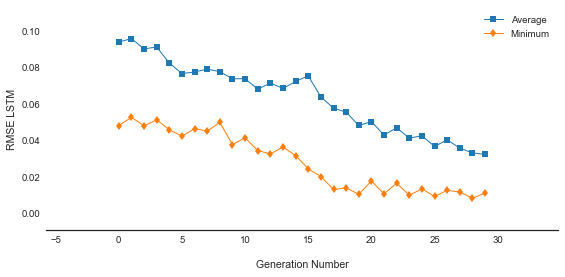

In [17]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.2)  

plt.figure(figsize=(8,4))
#avg1,min1,max1=scaler.inverse_transform([avg1,min1,max1])

plt.plot(gen1,avg1,marker='s',linewidth=1,markersize=6,label='Average')
plt.plot(gen1,min1,marker='d',linewidth=1,markersize=6,label='Minimum')
#plt.plot(gen1,max1,marker='*',linewidth=1,markersize=8,label='Maximum')
#plt.tick_params(left=False, labelleft=True)
#plt.box(False)
plt.margins(0.2)


plt.xlabel('Generation Number',labelpad=15)
plt.ylabel('RMSE LSTM')
#plt.xlim(-1, 26)
plt.legend(loc='best');
sns.despine(left=True)
plt.tight_layout()
plt.savefig('Fig1.png', bbox_inches='tight', dpi=400) 
plt.show()

## Output Decode

In [ ]:
print('\nReceived following best from PSO: ',best)
    
no_wins = int(best[0])
no_wins=remap(no_wins,5,86,1,5)

    
# Window length from 1 to 15
win_len =int(best[1])
window_length=remap(win_len,5,86,1,16)
    
# Max lookback upto 2047
first_win =int(best[2])
first_win=remap(first_win,5,86,1,2047)
    
sec_win =int(best[3])
sec_win=remap(sec_win,5,86,1,2047)
    
third_win =int(best[4])
third_win=remap(third_win,5,86,1,2047)
    
fourth_win=int(best[5])
fourth_win=remap(fourth_win,5,86,1,2047)
    
# Prevent Overlapping
if first_win-sec_win in list(range(0,21)):
    sec_win+=40
if first_win-sec_win in list(range(-21,0)):
    sec_win+=20
    
if first_win-third_win in list(range(0,21)):
    third_win+=40
if first_win-third_win in list(range(-21,0)):
    third_win+=20  
    
if first_win-fourth_win in list(range(0,21)):
    fourth_win+=40
if first_win-fourth_win in list(range(-21,0)):
    fourth_win+=20
        
if sec_win-third_win in list(range(0,21)):
    third_win+=40
if sec_win-third_win in list(range(-21,0)):
    third_win+=20
        
if sec_win-fourth_win in list(range(0,21)):
    fourth_win+=40
if sec_win-fourth_win in list(range(-21,0)):
    fourth_win+=20
        
if third_win-fourth_win in list(range(0,21)):
    fourth_win+=40
if third_win-fourth_win in list(range(-21,0)):
    fourth_win+=20
       
num_units = int(best[6])
if num_units >=100:
    num_units=90
        
# Minimum Batch Size is 25
batch_size = int(best[7])
batch_size=batch_size+20
    
act=int(best[8])
print('Activation No is',act)
act=remap(act,5,88,1,5)
print('Act Integer is:',act)
    
if act==1:
    act='selu'
elif act==2:
    act='elu'
elif act==3:
    act='relu'
elif act==4:
    act='tanh'

    
opt=int(best[9])
print ('Optimizer No is',opt)
opt=remap(opt,5,88,1,5)
print('Optimizer Integer is',opt)
    
if opt==1:
    opt='sgd'
elif opt==2:
    opt='RMSprop'
elif opt==3:
    opt='Adamax'
elif opt==4:
    opt='Adam'
    
    # Return fitness score of 100 if window_size or num_unit is zero
    #if no_wins==0 or window_length == 0 or num_units == 0 or batch_size==0:
    #return 1, 
    
if no_wins==1:
    lag=np.arange(first_win,first_win+window_length,1)
elif no_wins==2:
    lag1=np.arange(first_win,first_win+window_length,1)
    lag2=np.arange(sec_win,sec_win+window_length,1)
    lag=np.concatenate([lag1,lag2])
elif no_wins==3:
    lag1=np.arange(first_win,first_win+window_length,1)
    lag2=np.arange(sec_win,sec_win+window_length,1)
    lag3=np.arange(third_win,third_win+window_length,1)
    lag=np.concatenate([lag1,lag2,lag3])
elif no_wins==4:
    lag1=np.arange(first_win,first_win+window_length,1)
    lag2=np.arange(sec_win,sec_win+window_length,1)
    lag3=np.arange(third_win,third_win+window_length,1)
    lag4=np.arange(fourth_win,fourth_win+window_length,1)
    lag=np.concatenate([lag1,lag2,lag3,lag4])  
    
          
print('\n Number of Windows/Inputs to LSTM are:',no_wins)
print('Window Length: ', window_length)
print('1st Window Start: ',first_win)
print('2nd Window Start:',sec_win)
print('3rd Window Start:',third_win)
print('4th Window Start:',fourth_win)
    
print('Num of LSTM Units: ', num_units)
print('Batch Size is: ', batch_size)
print('Activation is: ', act)
print('Optimizer is: ', opt)
print('Lag created are:', lag)

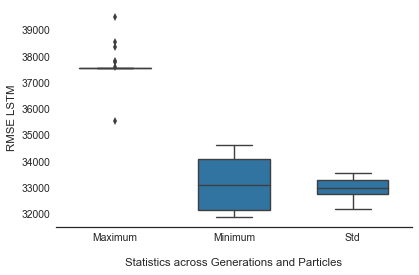

In [18]:
a,b,c=logbook.select('min','max','std')

a,b,c=scaler.inverse_transform([a,b,c])

df=pd.DataFrame({'Minimum':a,'Maximum':b, 'Std':c})

plt.figure(figsize=(6,4))
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
sns.boxplot(data=df, width=0.6,color='#1f77b4')
plt.xlabel('Statistics across Generations and Particles',labelpad=15)
plt.ylabel('RMSE LSTM')
sns.despine(left=True)
plt.tight_layout()
plt.show()

### Save Results

In [19]:
a,b,c,d,e=logbook.select('gen','avg','min','max','std')

b,c,d,e=scaler.inverse_transform([b,c,d,e])
df=pd.DataFrame({'Generation':a,'Average':b, 'Minimum':c,'Maximum':d,'Std':e})
writer = pd.ExcelWriter('PSO_new.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()


In [20]:
best_results=best
df=pd.DataFrame({'Best':best_results})
writer = pd.ExcelWriter('PSO_Best.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

## LOOP

In [ ]:
best_individuals = tools.selBest(pop,k = 3)

for bi in best_individuals:
    no_wins = int(bi[0])
    no_wins=remap(no_wins,5,86,1,5)

    
    # Window length from 1 to 15
    win_len =int(bi[1])
    window_length=remap(win_len,5,86,1,16)
    
    # Max lookback upto 2047
    first_win =int(bi[2])
    first_win=remap(first_win,5,86,1,2047)
    
    sec_win =int(bi[3])
    sec_win=remap(sec_win,5,86,1,2047)
    
    third_win =int(bi[4])
    third_win=remap(third_win,5,86,1,2047)
    
    fourth_win=int(bi[5])
    fourth_win=remap(fourth_win,5,86,1,2047)
    
    # Prevent Overlapping
    if first_win-sec_win in list(range(0,21)):
        sec_win+=40
    if first_win-sec_win in list(range(-21,0)):
        sec_win+=20
    
    if first_win-third_win in list(range(0,21)):
        third_win+=40
    if first_win-third_win in list(range(-21,0)):
        third_win+=20  
    
    if first_win-fourth_win in list(range(0,21)):
        fourth_win+=40
    if first_win-fourth_win in list(range(-21,0)):
        fourth_win+=20
        
    if sec_win-third_win in list(range(0,21)):
        third_win+=40
    if sec_win-third_win in list(range(-21,0)):
        third_win+=20
        
    if sec_win-fourth_win in list(range(0,21)):
        fourth_win+=40
    if sec_win-fourth_win in list(range(-21,0)):
        fourth_win+=20
        
    if third_win-fourth_win in list(range(0,21)):
        fourth_win+=40
    if third_win-fourth_win in list(range(-21,0)):
        fourth_win+=20
       
    num_units = int(bi[6])
    if num_units >=100:
        num_units=90
        
    # Minimum Batch Size is 25
    batch_size = int(bi[7])
    batch_size=batch_size+20
    
    act=int(bi[8])
    act=remap(act,5,88,1,5)
    
    if act==1:
        act='selu'
    elif act==2:
        act='elu'
    elif act==3:
        act='relu'
    elif act==4:
        act='tanh'

    
    opt=int(bi[9])
    opt=remap(opt,5,88,1,5)
    
    if opt==1:
        opt='sgd'
    elif opt==2:
        opt='RMSprop'
    elif opt==3:
        opt='Adamax'
    elif opt==4:
        opt='Adam'
    
    # Return fitness score of 100 if window_size or num_unit is zero
    #if no_wins==0 or window_length == 0 or num_units == 0 or batch_size==0:
    #return 1, 
    
    if no_wins==1:
        lag=np.arange(first_win,first_win+window_length,1)
    elif no_wins==2:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag=np.concatenate([lag1,lag2])
    elif no_wins==3:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag3=np.arange(third_win,third_win+window_length,1)
        lag=np.concatenate([lag1,lag2,lag3])
    elif no_wins==4:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag3=np.arange(third_win,third_win+window_length,1)
        lag4=np.arange(fourth_win,fourth_win+window_length,1)
        lag=np.concatenate([lag1,lag2,lag3,lag4])  
    
          
    print('\n Number of Windows/Inputs to LSTM are:',no_wins, 'Window Length: ', window_length,
          '1st Window Start: ',first_win, '2nd Window Start:',sec_win, '3rd Window Start:',third_win,
          '4th Window Start:',fourth_win, 'Num of LSTM Units: ', num_units, 'Batch Size is: ', 
          batch_size, 'Activation is: ', act, 'Optimizer is: ', opt,'Lag created are:', lag)

## Manual Scraping

In [ ]:
def find(substr,substr1, infile, outfile):
    with open(infile) as a, open(outfile, 'w') as b:
        for line in a:
            if substr in line:
                b.write(line + '\n')
            if substr1 in line:
                b.write(line + '\n')

In [ ]:
find('Validation RMSE:','Current Generation is', 'failed_PSO.txt','res.txt')

In [ ]:
colnames=['val']
df= pd.read_csv('res.txt',names=colnames, header=None)
df['A'], df['B'] = df['val'].str.split(':', 1).str
df.head()
new_df = df[df.A != 'Current Generation is']
new_df

In [ ]:
first_win=78
third_win=90

In [ ]:
first_win=50
sec_win=80

#1 & 2
if first_win-sec_win in list(range(0,41)):
    if sec_win>48:
        sec_win-=48
    else:
        sec_win+=96
if first_win-sec_win in list(range(-39,0)):
    sec_win+=30

print(first_win)
print(sec_win)

In [ ]:
if first_win-third_win in list(range(-16,16)):
    print('yes')
else:
    print('no')

## New Code

In [17]:
def neuralnet(individual):

def train_evaluate(individual):
    df1= df.copy(deep=True)
    #print('Original Data Shape', df1.shape)
    
    # Paramerts to be optimized 

    print('\nReceived following inputs from PSO: ',individual)
    
    # Parameter 1 : No of Windows
    no_wins = int(individual[0])
    no_wins=remap(no_wins,-40,40,1,5)
    #print('Number of Windows:',no_wins)
    if no_wins==5:
        no_wins=2
    if no_wins==0:
        no_wins=3
    if no_wins>=6 or no_wins<0:
        return 0.10,
    
    # # Parameter 2 : Window length from 4 to 16
    win_len =int(params[1])
    window_length=remap(win_len,-40,40,3,18)
    if window_length>18 or window_length<3:
        return 0.10,
    
    # Max lookback upto 1440
    first_win =int(params[2])
    first_win=remap(first_win,-40,40,100,1)
    if first_win==0:
        first_win+=1
    if first_win in np.arange(-12,1): 
        first_win=abs(first_win) 
    if first_win>100:
        return 0.10
    
    sec_win =int(params[3])
    sec_win=remap(sec_win,-40,40,1400,1)
    if sec_win==0:
        sec_win+=1
    if sec_win in np.arange(-12,1): 
        sec_win=abs(sec_win) 
    if sec_win>1400 or sec_win<-12:
        return 0.10,
    
    third_win =int(params[4])
    third_win=remap(third_win,-40,40,1400,1)
    if third_win==0:
        third_win+=1
    if third_win in np.arange(-12,1): 
        third_win=abs(third_win) 
    if third_win>1400 or third_win<-12:
        return 0.10,
    
    fourth_win=int(params[5])
    fourth_win=remap(fourth_win,10,80,1400,1)
    if fourth_win==0:
        fourth_win+=1
    if fourth_win in np.arange(-10,1): 
        fourth_win=abs(fourth_win) 
    if fourth_win>1400 or fourth_win<-10:
        return 0.10,
    
    # Prevent Overlapping
        #1 & 2
    if first_win-sec_win in list(range(0,41)):
        if sec_win>48:
            sec_win-=40
        else:
            sec_win+=96
    if first_win-sec_win in list(range(-39,0)):
        sec_win+=30
    
    #1 & 3
    if first_win-third_win in list(range(0,41)):
        if third_win>48:
            third_win-=40
        else:
            third_win+=96
    if first_win-third_win in list(range(-39,0)):
        third_win+=30  
        
    # 1 & 4
    if first_win-fourth_win in list(range(0,41)):
        if fourth_win>48:
            fourth_win-=40
        else:
            fourth_win+=96
            
    if first_win-fourth_win in list(range(-39,0)):
        fourth_win+=30
    
    #2 & 3
    if sec_win-third_win in list(range(0,41)):
        if third_win>48:
            third_win-=40
        else:
            third_win+=96
    if sec_win-third_win in list(range(-39,0)):
        third_win+=30
    #Rep
    if first_win-third_win in list(range(-16,16)):
        return 0.10,
              
    #
     #2 & 4   
    if sec_win-fourth_win in list(range(0,41)):
        if fourth_win>48:
            fourth_win-=40
        else:
            fourth_win+=96
    if sec_win-fourth_win in list(range(-39,0)):
        fourth_win+=30
    #Rep
    if first_win-fourth_win in list(range(-16,16)):
        return 0.10,
        
    
    # 3 & 4    
    if third_win-fourth_win in list(range(0,41)):
        if fourth_win>48:
            fourth_win-=40
        else:
            fourth_win+=96
    if third_win-fourth_win in list(range(-39,0)):
        fourth_win+=30
    #Rep
    if first_win-fourth_win in list(range(-16,16)):
        return 0.10,
    if sec_win-fourth_win in list(range(-16,16)):
        return 0.10,
    
           
    num_units = int(params[6])
    num_units=abs(num_units)
    num_units+=20
    if num_units>=100:
        num_units=90
        
    # Minimum Batch Size is 25
    batch_size = int(params[7])
    batch_size=abs(batch_size)
    batch_size=batch_size+25
    if batch_size>150:
        return 0.10,
    
    act=int(params[8])
    print('Activation No is',act)
    act=remap(act,-40,40,1,5)
    print('Act Integer is:',act)
    
    if act==1:
        act='selu'
    elif act==2:
        act='elu'
    elif act==3:
        act='relu'
    elif act==4:
        act='tanh'
    elif act>=5 or act<1:
        return 0.10,

    
    opt=int(params[9])
    print ('Optimizer No is',opt)
    opt=remap(opt,-40,40,1,5)
    print('Optimizer Integer is',opt)
    
    if opt==1:
        opt='sgd'
    elif opt==2:
        opt='RMSprop'
    elif opt==3:
        opt='Adamax'
    elif opt==4:
        opt='Adam'
    elif opt>=5 or opt<1:
        return 0.10,
    
    # Return fitness score of 100 if window_size or num_unit is zero
    #if no_wins==0 or window_length == 0 or num_units == 0 or batch_size==0:
    #return 1, 
    
    if no_wins==1:
        lag=np.arange(first_win,first_win+window_length,1)
    elif no_wins==2:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag=np.concatenate([lag1,lag2])
    elif no_wins==3:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag3=np.arange(third_win,third_win+window_length,1)
        lag=np.concatenate([lag1,lag2,lag3])
    elif no_wins==4:
        lag1=np.arange(first_win,first_win+window_length,1)
        lag2=np.arange(sec_win,sec_win+window_length,1)
        lag3=np.arange(third_win,third_win+window_length,1)
        lag4=np.arange(fourth_win,fourth_win+window_length,1)
        lag=np.concatenate([lag1,lag2,lag3,lag4])  
    
    for col in df1.columns:
        for l in lag:
            df1.loc[:,col+"_"+str(l)] = df1[col].shift(l)
        
    df1.dropna(how='any',inplace=True)
    dataset = df1.values # Converted dataframe to numpy ndarray
    dataset = dataset.astype('float32')
    print('\nDataset shape after creating new lags:',dataset.shape)
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))
    
    trainX=train[:,1:]
    trainY=train[:,0]
    testX=test[:,1:]
    testY=test[:,0]
    
          
    print('\n Number of Windows/Inputs to LSTM are:',no_wins)
    print('Window Length: ', window_length)
    print('1st Window Start: ',first_win)
    print('2nd Window Start:',sec_win)
    print('3rd Window Start:',third_win)
    print('4th Window Start:',fourth_win)
    
    print('Num of LSTM Units: ', num_units)
    print('Batch Size is: ', batch_size)
    print('Activation is: ', act)
    print('Optimizer is: ', opt)
    print('Lag created are:', lag)
    
    
    #LSTM
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0],window_length,(no_wins)))
    testX = np.reshape(testX, (testX.shape[0],window_length,(no_wins)))
    print('Train X shape after np.reshape',trainX.shape)
    print('Test X shape after np.reshape',testX.shape)
    print('Train Y Shape',trainY.shape)
    print('Test Y Shape',testY.shape)
      
    # Train LSTM model and predict on validation set
    #inputs = Input(shape=(window_size,1))
    model = Sequential() # New Instance of Model Object
    model.add(LSTM(num_units, input_shape=(window_length,(no_wins))))
    model.add(Dense(30, activation=act))
    model.add(Dense(10, activation=act))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=opt,loss='mean_squared_error')
    #model.fit(trainX, trainY, epochs=1, batch_size=10,shuffle=True)
    
    start = time.time()
    model.fit(trainX, trainY, epochs=50, shuffle=True,batch_size=batch_size, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)
    
    y_pred = model.predict(testX)
    end = time.time()
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(testY, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    print ("Model took %0.2f seconds to train"%(end - start))
    return rmse,


    
    # need to figure out a sensible way to put in the hyperparameter values 
    # maximise
    # Hardcoding method: kernel_size, pooling_size, dropout_rate are currently default 
    # Expecting that the first individual is ref num_conv_filters and 2nd ind is 
    # num_dense_outputs 
    num_conv_filters = int(individual[0])
    num_dense_outputs = int(individual[1])
    kernel_size = int(individual[2])
    pooling_size = int(individual[3])
    dropout_rate = individual[4]

    validation_accuracy = train_model(num_conv_outputs = num_conv_filters, 
                                      num_dense_outputs = num_dense_outputs,
                                      kernel_size = kernel_size, 
                                      pooling_size = pooling_size, 
                                      dropout_rate = dropout_rate) 
    return validation_accuracy,

IndentationError: expected an indented block (<ipython-input-17-dc793e6e901a>, line 3)

In [4]:
import numpy as np
import time

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

from scoop import futures

In [6]:
GMAX = 30              # Max number of generations
DELTA = 1e-7           # Smallest position increment allowed
EPSILON = 1e-7         # Smallest fitness value increment allowed
DIM = 5                # No. of Dimensions in the problem
POPULATION = 20        # Size of the particle Swarm

In [7]:
# --------------------------Swarm operations ---------------------------------
# Creates a fitness object that minimises its fitness value

creator.create("Fitness", 
               base.Fitness, 
               weights=(-1.0,))

# Creates a particle with initial declaration of its contained attributes
creator.create("Particle", 
               np.ndarray, 
               fitness=creator.Fitness, 
               velocity=np.ndarray(DIM), 
               bd_min=np.ndarray(DIM),       # Boundary min of each dim
               bd_max=np.ndarray(DIM),       # Boundary max of each dim
               best_known=None)

C:\Users\Ali\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [8]:
# generates and returns a particle based on the dim (size) of the problem
def generate(bound_l, bound_u):

    # Hardcoded bounds: for now assume that the first ind is num_conv_filt and 2nd is num_dense_out 
    num_conv_filters = np.random.randint(1,512)
    num_dense_out = np.random.randint(1,512)
    kernel_size = np.random.randint(1,4)
    pooling_size = np.random.randint(1,4)
    dropout_rate = np.random.uniform(0,1)

    particle = creator.Particle([num_conv_filters, num_dense_out, kernel_size,
                                 pooling_size, dropout_rate])
    
    # Original particle creation
    # particle = creator.Particle(np.random.uniform(bound_l,bound_u) for _ in range(DIM))
    bound = bound_u - bound_l
    particle.bd_min = np.array([1, 1, 1, 1, 0])
    particle.bd_max = np.array([512, 512, 4, 4, 1])
    particle.velocity = np.array([np.random.uniform(-abs(bound), abs(bound)) for _ in range(DIM)])
    particle.best_known = creator.Particle(particle)
    return particle

In [9]:
# updating the velocity and position of the particle
def updateParticle(particle, best, generator, w, phi_p, phi_g):

    # NOTE: when updating the particle, we need to consider how to bound various inputs being optimised 

    r_p = np.array([generator.uniform(0,1) for _ in particle])
    r_g = np.array([generator.uniform(0,1) for _ in particle])
    #NOTE: random seed is the same in each process, so in parallel, the performance is poor

    p = np.subtract(particle.best_known, particle)
    g = np.subtract(best, particle)

    v_p = phi_p * np.multiply(p, r_p)
    v_g = phi_g * np.multiply(g, r_g)

    v_w = w * particle.velocity
    particle.velocity[:] = np.add(v_w, np.add(v_p, v_g))
    particle[:] = np.add(particle, particle.velocity)

    # Takes the bigger of either the new particle position or the minimum boundary value
    particle[:] = np.maximum(particle.bd_min, particle)

    # Takes the smaller of either the new particle position or the maximum boundary value 
    particle[:] = np.minimum(particle.bd_max, particle)

In [10]:
# initialise the swarm with fitness values.
def initialiseSwarm(particle):

    # assigning the fitness values and initialising best known position
    particle.fitness.values = toolbox.evaluate(particle)
    particle.best_known.fitness.values = particle.fitness.values

    return particle.fitness.values

In [ ]:
# updates a particle with new values
def updateSwarm(particle, best, generator):

    # move the particles with the update function and eval new fitness
    toolbox.update(particle, best, generator)
    particle.fitness.values = toolbox.evaluate(particle)

    # if the particle output is better than the best known output, update the
    # best known for this particle
    if particle.fitness.values > particle.best_known.fitness.values:

        particle.best_known = creator.Particle(particle)
        particle.best_known.fitness.values = particle.fitness.values

        # if the particle best known happens to be better than the global best
        # then also update the global best value 
        if particle.best_known.fitness.values > best.fitness.values:

            best = creator.Particle(particle.best_known)
            best.fitness.values = particle.best_known.fitness.values

    # tim.sleep(5)    # simulating long computation time
    return best

In [11]:
def createBest(best):
    particle = creator.Particle(best)
    particle.fitness.values = best.fitness.values
    return particle

In [14]:
# ---------------------- toolbox -------------------------------------
# registering all the functions to the toolbox for more convenient access
# by assignment default parameter values. To use these functions call
# toolbox.<functionname>
toolbox = base.Toolbox()

# deep evaluations function has default arguments defined in the deep.py file 
# The arguments that can be changed are: 
#      num_classes: fixed,
#      num_rows: fixed,
#      num_cols: fixed,
#      num_channels: fixed,
#      num_epochs: fixed,
#      num_conv_filters,
#      kernel_size,
#      pooling_size,
#      dropout_rate,
#      num_dense_out
toolbox.register("evaluate", neuralnet)
# toolbox.register("evaluate", neuralnet, num_classes=10, num_rows=8, num_cols=8, num_channels=1, num_epochs=2)
toolbox.register("particle", generate, bound_l=-5, bound_u=5)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi_p=0.8, phi_g=0.8, w=0.8)
toolbox.register("map", futures.map)

In [15]:
# ---------------------------------------------------------------------
def main():

    # initialise the swarm of particles with their fitness values
    pop = toolbox.population(n=POPULATION)
    fitness = list(map(initialiseSwarm, pop))

    # initialise the global best particle in the swarm
    best = creator.Particle(pop[fitness.index(max(fitness))])
    best.fitness.values = pop[fitness.index(max(fitness))].fitness.values

    # create a list of global best particles so that we can map each particle
    # to a global best value when updating the particle positions. At the same time,
    # create a list of random generators so that each process runs with a different seed
    # as this also impacts the performance of the algorithm
    global_best = []
    random_generators = []
    for _ in range(POPULATION):
        global_best.append(createBest(best))
        random_generators.append(np.random.RandomState())

    g = 1
    while g <= GMAX:

        # update the particles in the swarm and return a list of the new global
        # best particles
        global_best = list(toolbox.map(updateSwarm, pop, global_best, random_generators))

        # calculate the best global best from the list and create a new global
        # best list
        best = creator.Particle(global_best[0])
        best.fitness.values = global_best[0].fitness.values

        for n in range(1, POPULATION):
            if global_best[n].fitness.values > best.fitness.values:
                best = creator.Particle(global_best[n])
                best.fitness.values = global_best[n].fitness.values

        global_best = []
        for _ in range(POPULATION):
            global_best.append(createBest(best))

        # iterate the generation
        g = g + 1

    return pop, best, best.fitness.values

In [16]:
if __name__ == "__main__":
    print(main())

NameError: name 'train_model' is not defined